# Importación de Bibliotecas y Configuración de Hiperparámetros
Hiperparametros:
BATCH_SIZE = 64: es un valor estandar equilibrado para eficiencia computacional, podriamos usar 32 a 128

Z_DIM = 100: el paper de dcgan utilizaba 100 como dimension del ruido latente  

MG_SIZE = 28: las imagenes de fashionmnist son de 28x28 pixeles

CHANNELS = 1: fashionmnist es en escala de grises, entonces usamos un solo canal

NUM_EPOCHS = 50: usamos 50 epochs por el tiempo, seria mejor utilizar hasta 100 epochs

LR = 0.0002: esta taza de aprendizaje se usa para  explosiones de gradientes en transformers

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparámetros
BATCH_SIZE = 64
Z_DIM = 100  # Dimensión del ruido
IMG_SIZE = 28
CHANNELS = 1
NUM_EPOCHS = 50
LR = 0.0002

# Carga del Dataset FashionMNIST

ToTensor() convierte imágenes a tensores flotantes [0,1], y Normalize(mean=0.5, std=0.5) centra los datos en [-1,1] para alinearse con la activación de tanh del generador

shuffle=True para muestreo estocástico, asi minimizamos correlacion secuencial

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.08MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.3MB/s]


# Definición del Generador con Encoder Transformer

Arquitectura: proyecta ruido z (dim=100) a secuencia de tokens (num_patches=49, embed_dim=64) usando nn.Linear, añade embeddings posicionales para codificar relaciones espaciales 

parametros:

embed_dim=64: dimension pequeña porque mnist es pequeño (28x28)

num_heads=4: número moderado para atención multi-head en modelos pequeños, así conseguimos diversidad en la atención

num_layers=3: profundidad mínima para capturar características complejas sin hacer overfitting

patch_size=4: para 28x28, 4x4 genera 49 patches (7x7) y captura detalles finos sin demasiados tokens, es mejor que 14x14 (pocos patches) para atención global en las imágenes pequeñas de fashionmninst 

dropout=0.1: valor estándar para regularización en Transformers

In [3]:
class TransformerGenerator(nn.Module):
    def __init__(self, z_dim=100, embed_dim=64, num_heads=4, num_layers=3, patch_size=4, img_size=28, channels=1):
        super(TransformerGenerator, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.channels = channels
        
        # Proyección del ruido a secuencia de tokens
        self.proj = nn.Linear(z_dim, self.num_patches * embed_dim)
        
        # Embedding posicional
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        
        # Encoder Transformer con batch_first=True
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True  # Fix for warning
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Proyección a valores de patches
        self.to_patch = nn.Linear(embed_dim, channels * patch_size * patch_size)
    
    def forward(self, z):
        # Proyectar ruido a secuencia
        batch_size = z.size(0)
        x = self.proj(z).view(batch_size, self.num_patches, self.embed_dim)
        
        # Añadir posición
        x = x + self.pos_embed
        
        # Transformer (src_mask=None para full attention)
        x = self.transformer(x)
        
        # A patches
        x = self.to_patch(x)
        
        # Reconstruir imagen de patches
        x = x.view(batch_size, int(self.num_patches**0.5), int(self.num_patches**0.5), self.channels, self.patch_size, self.patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5)
        x = x.contiguous().view(batch_size, self.channels, self.img_size, self.img_size)
        
        return torch.tanh(x)  # Salida en [-1, 1]

# Definición del Discriminador

Arquitectura: nn.Sequential con convoluciones 2D (stride=2 para pooling implícito, padding=1 para preservar bordes). Canales aumentan (64->128->256) para compresión de características

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels=1, features_d=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, features_d, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1),  # 7x7 -> 3x3
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features_d*4, 1, kernel_size=3, stride=1, padding=0),  # 3x3 -> 1x1
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

# Definición del Generador DCGAN

Arquitectura: ConvTranspose2d para deconvoluciones (stride=2 para duplicar resolución). Canales disminuyen (256->128->64->1) para expansión espacial (1x1->4x4->8x8->16x16->28x28)

BatchNorm2d y ReLU estabilizan y añaden no-linealidad, asi prevenimos colapso de activaciones
tanh para salida normalizada

In [5]:
class DCGenerator(nn.Module):
    def __init__(self, z_dim=100, channels=1, features_g=64):
        super(DCGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g*4, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features_g*2, features_g, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features_g, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z.view(z.size(0), z.size(1), 1, 1))

# Visualización de Muestras

In [6]:
import torchvision.utils as vutils

def visualize_samples(generator, fixed_noise, epoch, save_path="samples"):
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).cpu()
        # Desnormalizar de [-1, 1] a [0, 1] para visualización
        fake_imgs = (fake_imgs + 1) / 2
        grid = vutils.make_grid(fake_imgs[:16], nrow=4, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis("off")
        plt.title(f"Generated Images at Epoch {epoch}")
        plt.savefig(f"{save_path}/epoch_{epoch}.png")
        plt.show()

# Entrenamiento

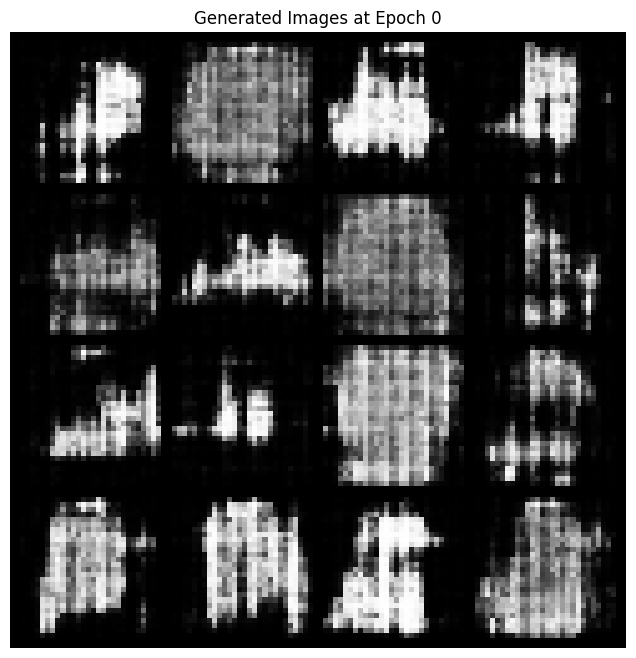

Transformer-GAN Epoch [0/50] Loss D: 0.1396, Loss G: 3.5268


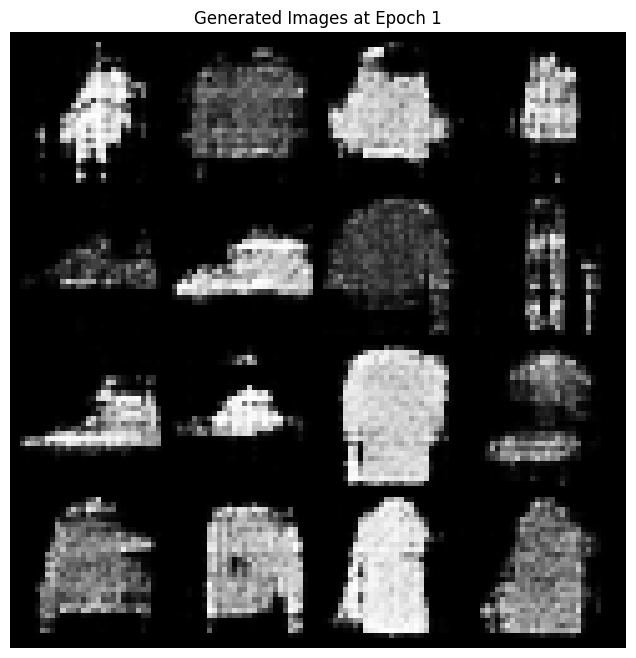

Transformer-GAN Epoch [1/50] Loss D: 0.0581, Loss G: 6.3719


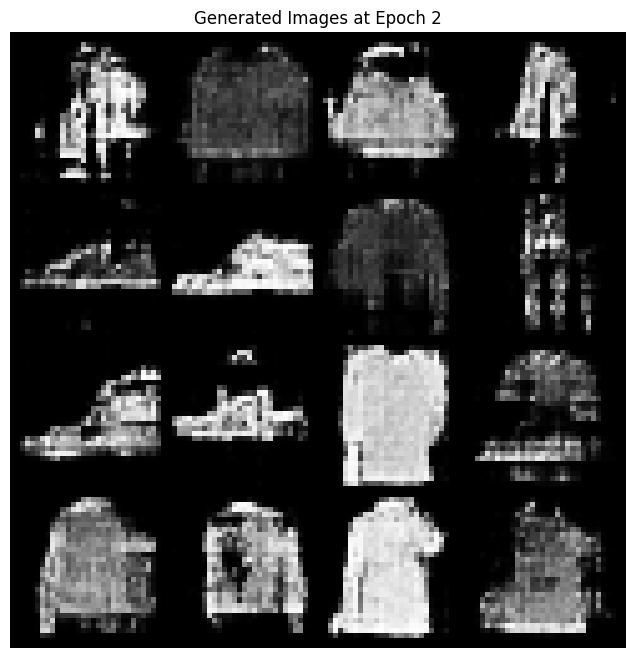

Transformer-GAN Epoch [2/50] Loss D: 0.0269, Loss G: 4.5940


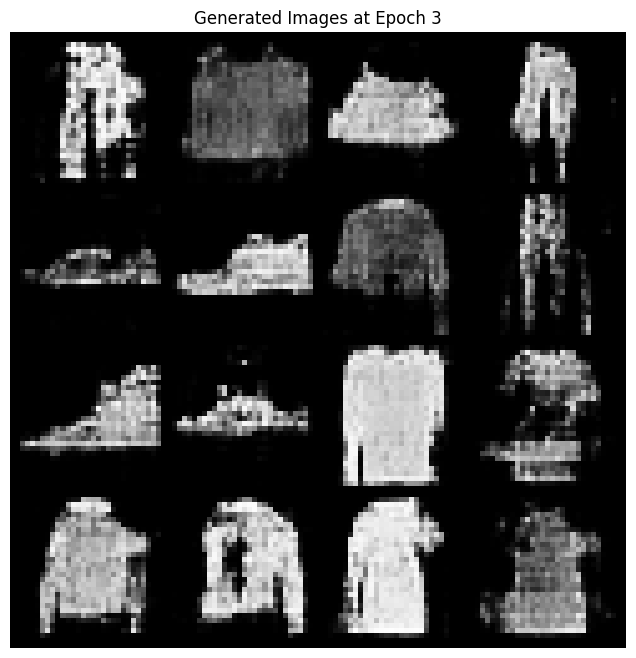

Transformer-GAN Epoch [3/50] Loss D: 0.0095, Loss G: 5.4785


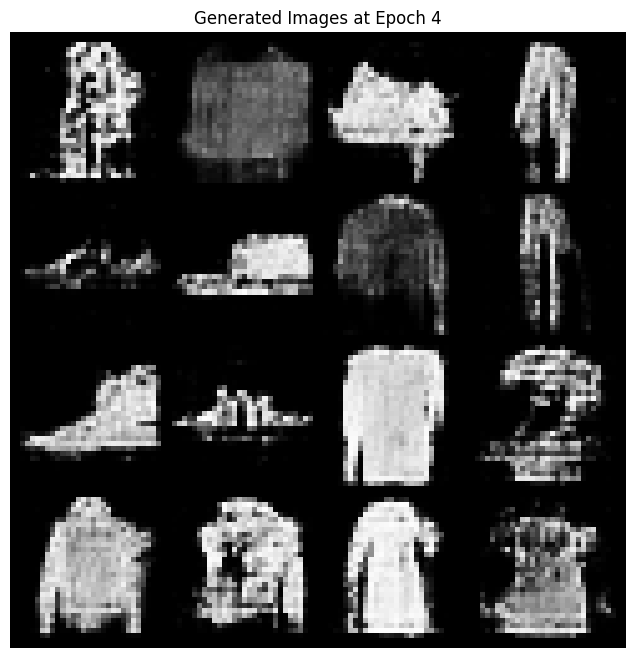

Transformer-GAN Epoch [4/50] Loss D: 0.0301, Loss G: 6.1394


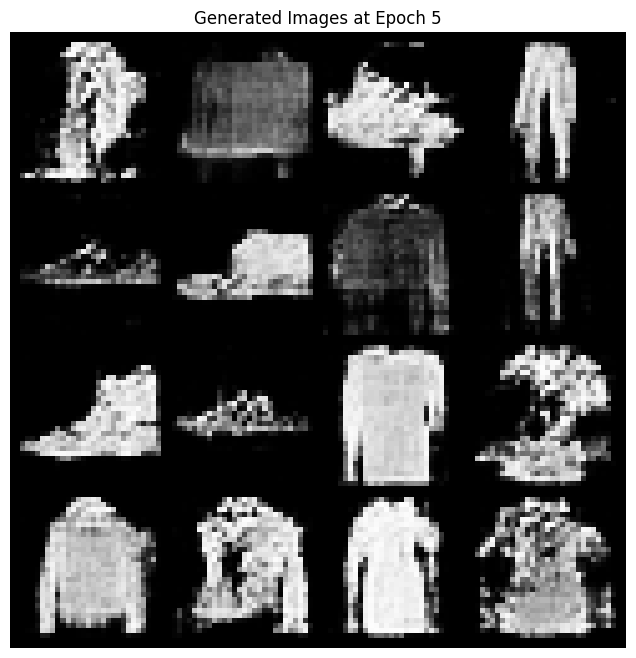

Transformer-GAN Epoch [5/50] Loss D: 0.0266, Loss G: 4.5004


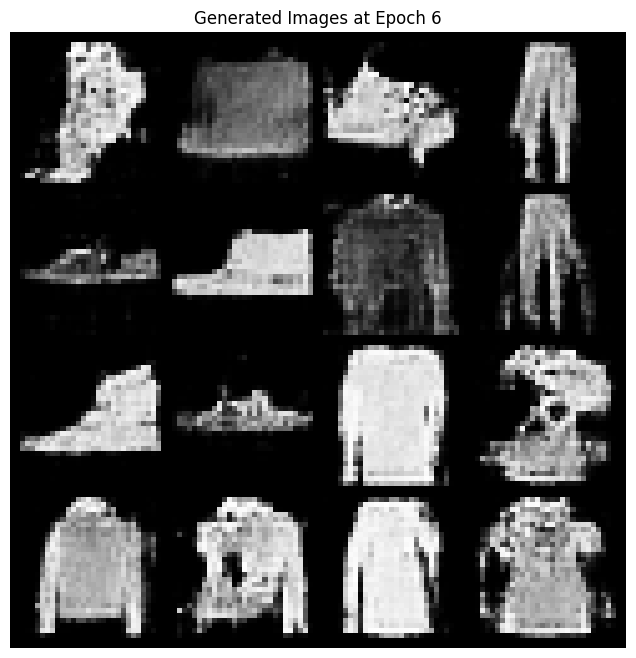

Transformer-GAN Epoch [6/50] Loss D: 0.0930, Loss G: 9.8823


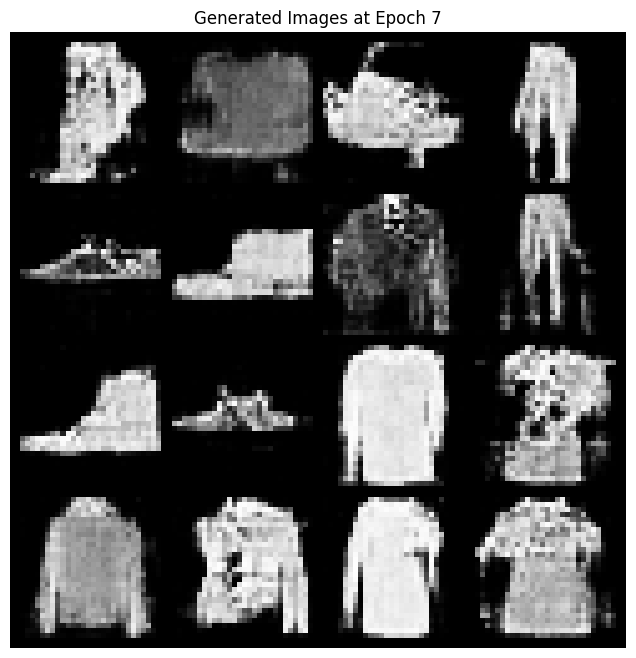

Transformer-GAN Epoch [7/50] Loss D: 0.0588, Loss G: 3.9357


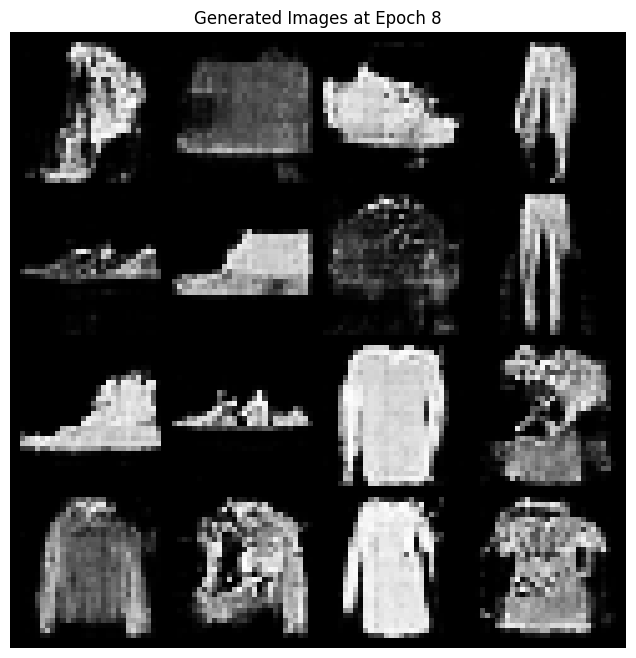

Transformer-GAN Epoch [8/50] Loss D: 0.0105, Loss G: 5.0161


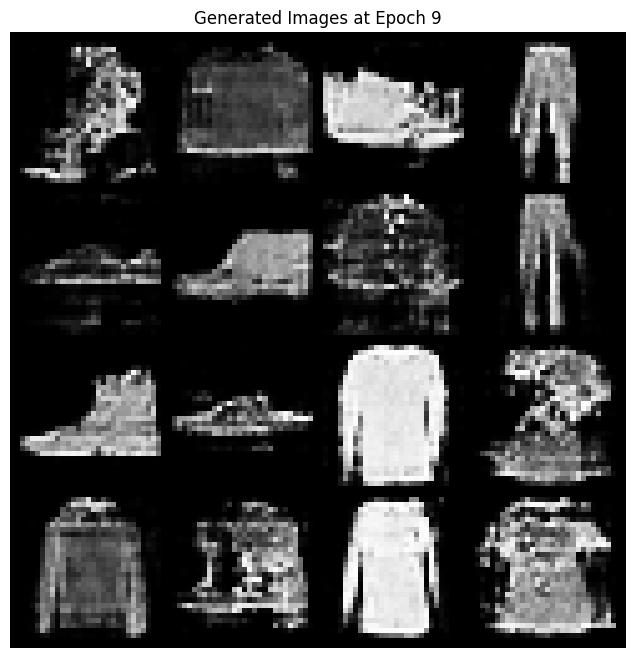

Transformer-GAN Epoch [9/50] Loss D: 0.0479, Loss G: 5.2843


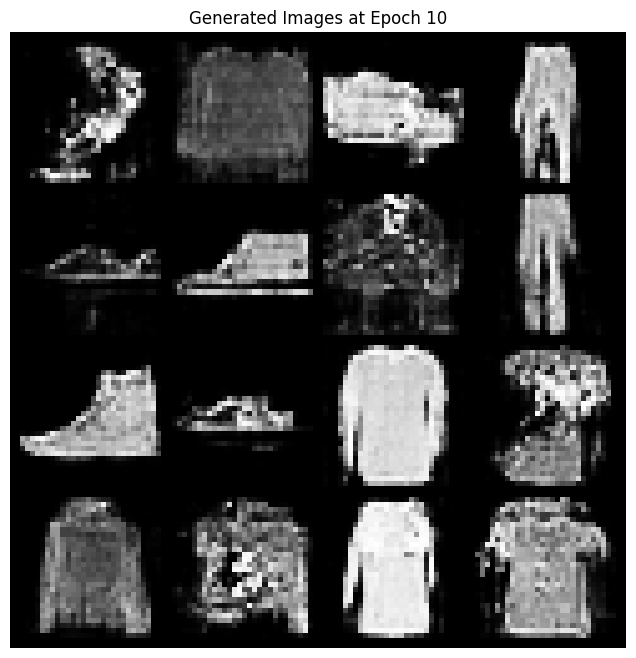

Transformer-GAN Epoch [10/50] Loss D: 0.0046, Loss G: 7.2528


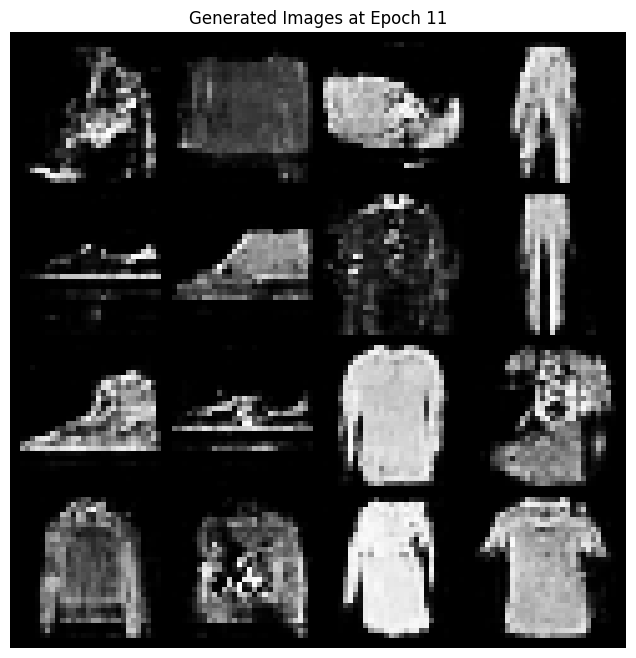

Transformer-GAN Epoch [11/50] Loss D: 0.0061, Loss G: 7.6375


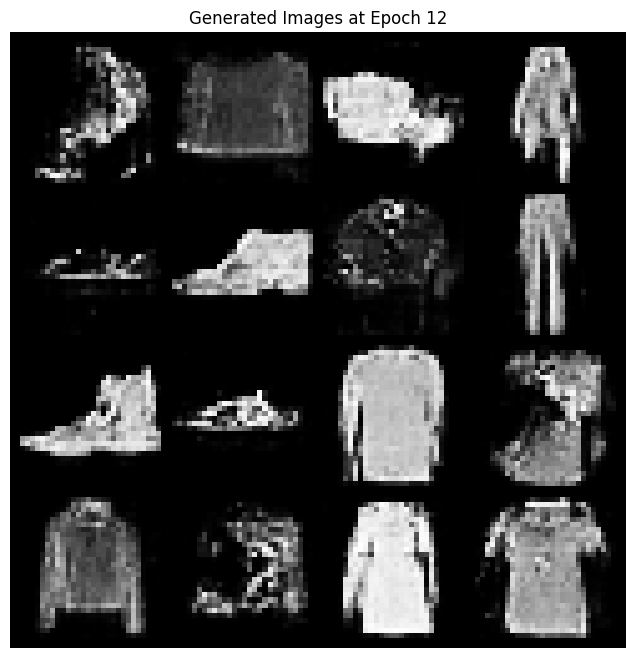

Transformer-GAN Epoch [12/50] Loss D: 0.0057, Loss G: 6.6543


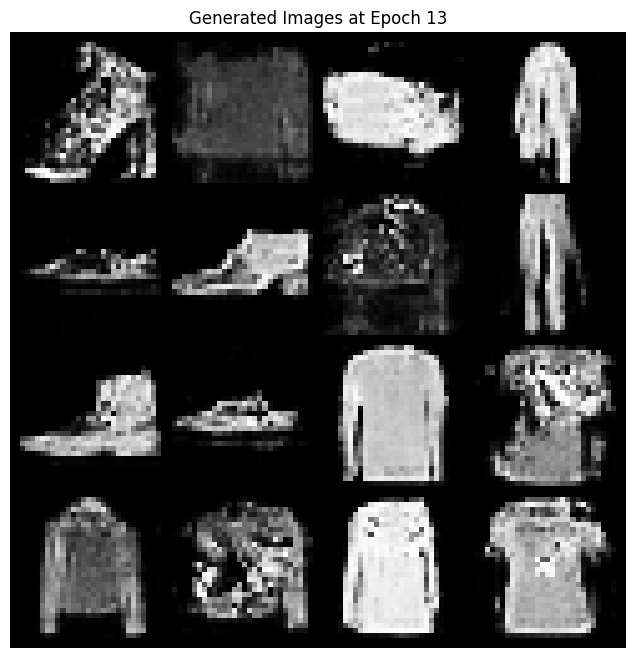

Transformer-GAN Epoch [13/50] Loss D: 0.0066, Loss G: 6.4885


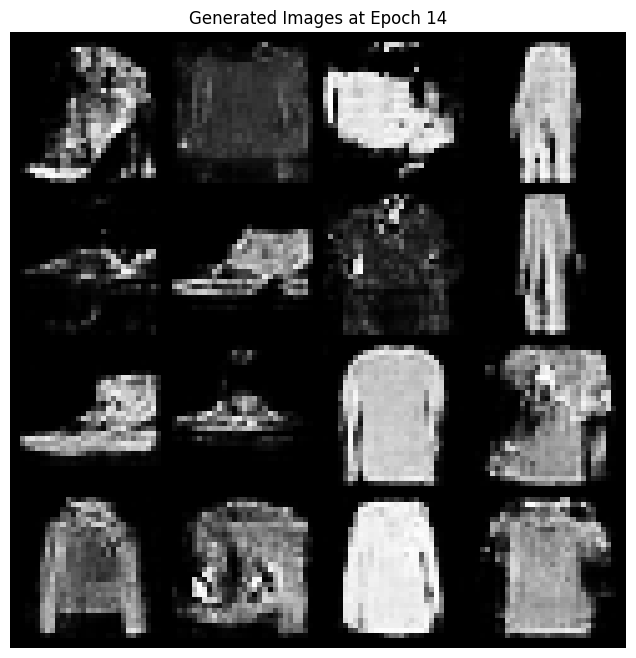

Transformer-GAN Epoch [14/50] Loss D: 0.0066, Loss G: 4.9928


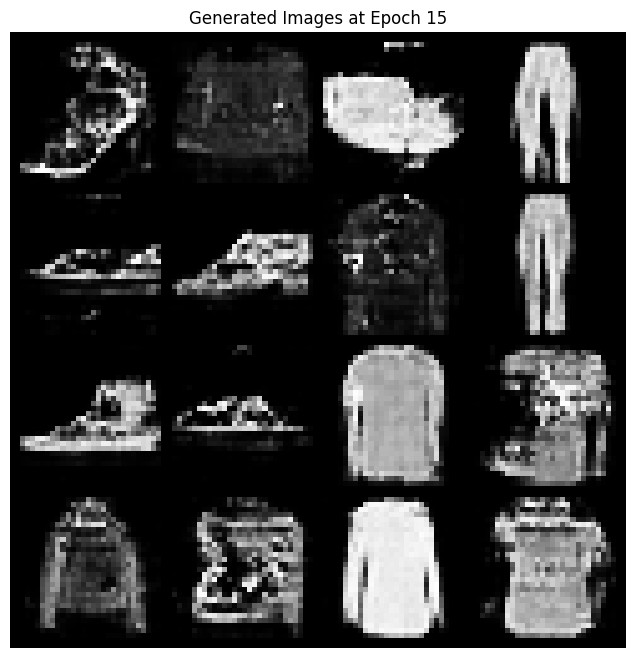

Transformer-GAN Epoch [15/50] Loss D: 0.1175, Loss G: 8.3285


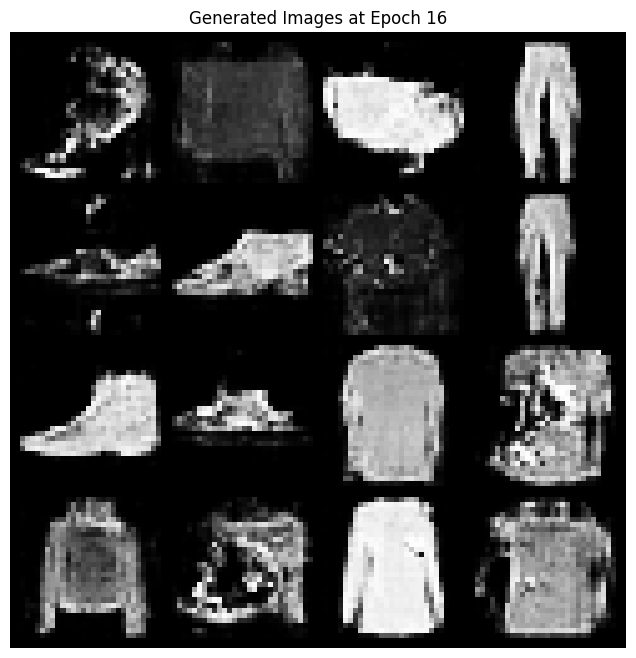

Transformer-GAN Epoch [16/50] Loss D: 0.0078, Loss G: 5.8730


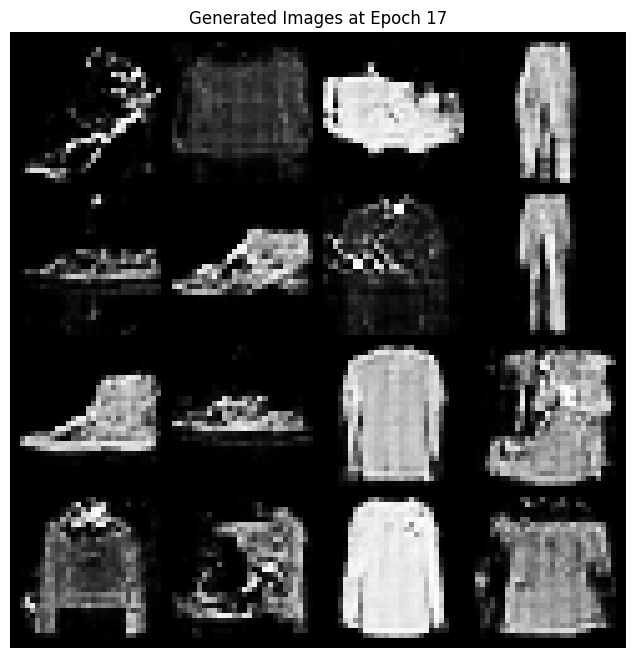

Transformer-GAN Epoch [17/50] Loss D: 0.0271, Loss G: 5.6853


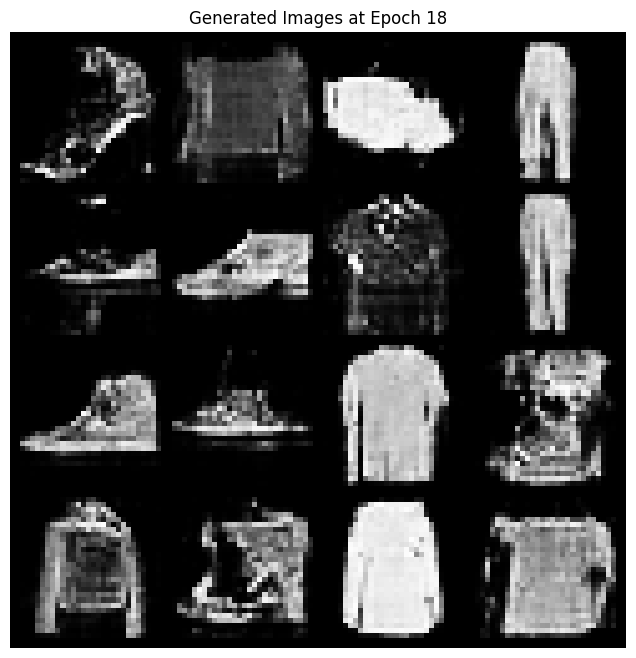

Transformer-GAN Epoch [18/50] Loss D: 0.1090, Loss G: 8.1194


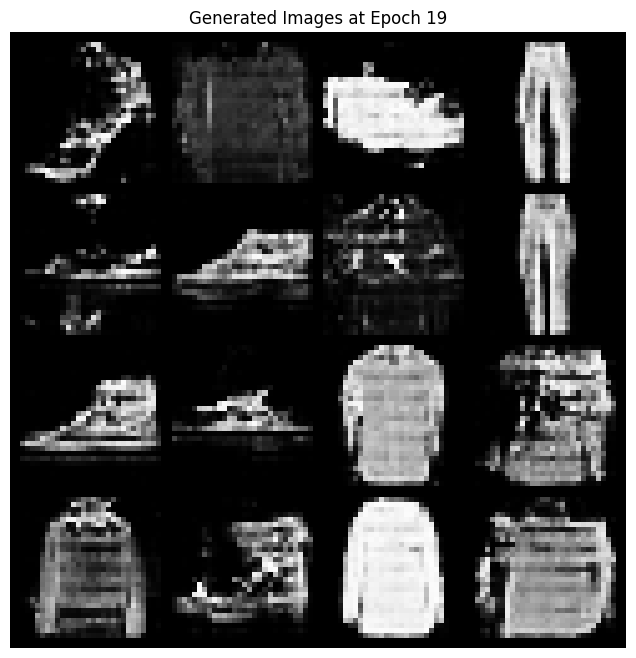

Transformer-GAN Epoch [19/50] Loss D: 0.0246, Loss G: 5.7500


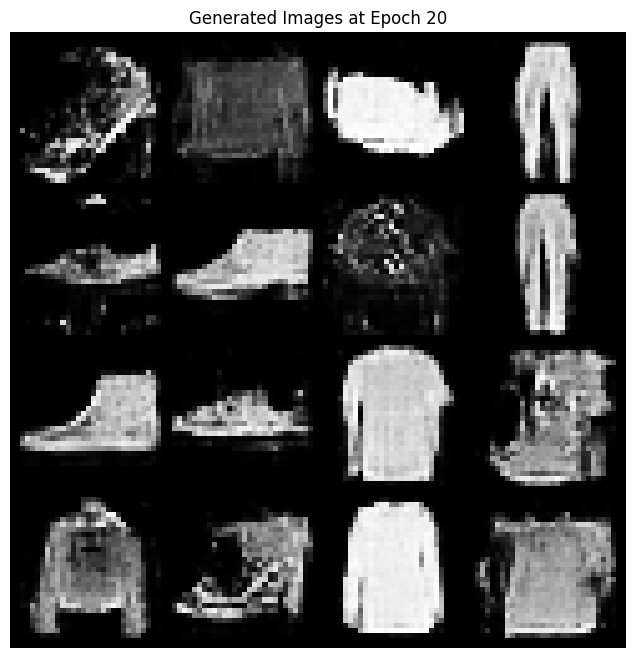

Transformer-GAN Epoch [20/50] Loss D: 0.0216, Loss G: 5.1906


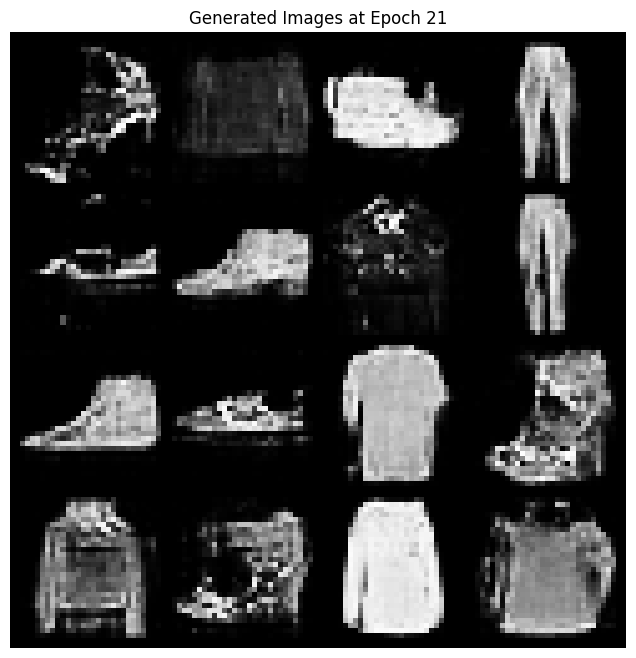

Transformer-GAN Epoch [21/50] Loss D: 0.0054, Loss G: 6.3346


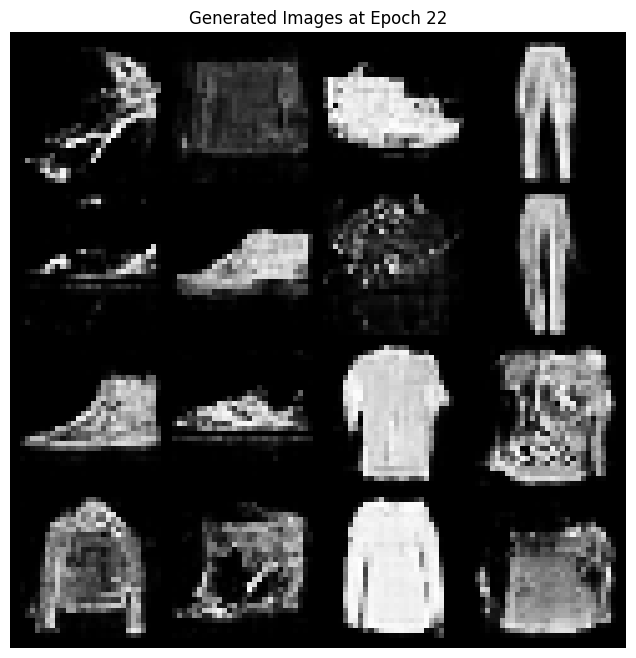

Transformer-GAN Epoch [22/50] Loss D: 0.0049, Loss G: 6.8086


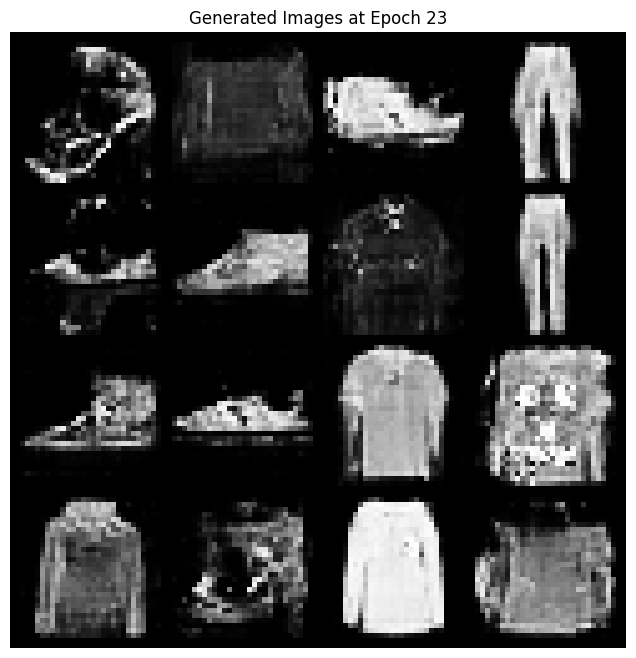

Transformer-GAN Epoch [23/50] Loss D: 0.0047, Loss G: 6.1005


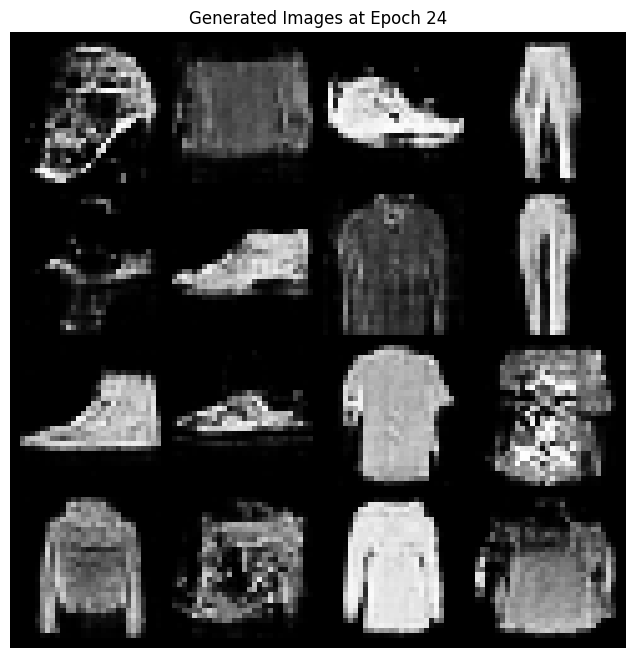

Transformer-GAN Epoch [24/50] Loss D: 0.0078, Loss G: 6.0832


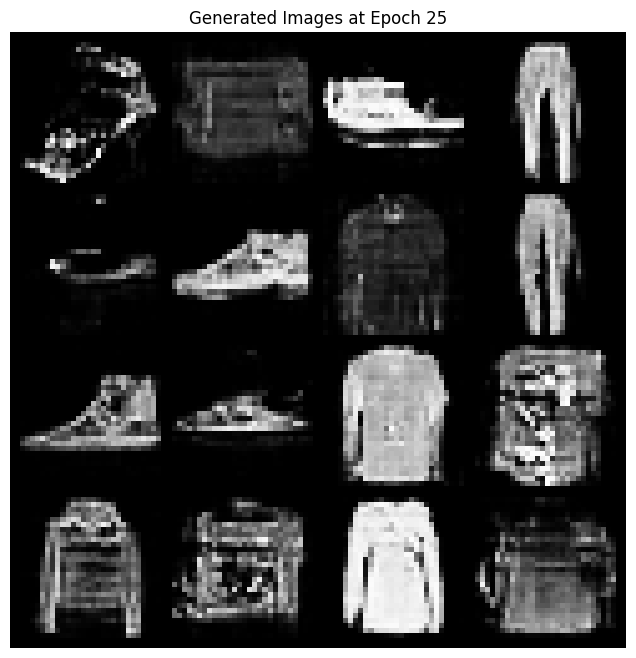

Transformer-GAN Epoch [25/50] Loss D: 0.0012, Loss G: 9.5523


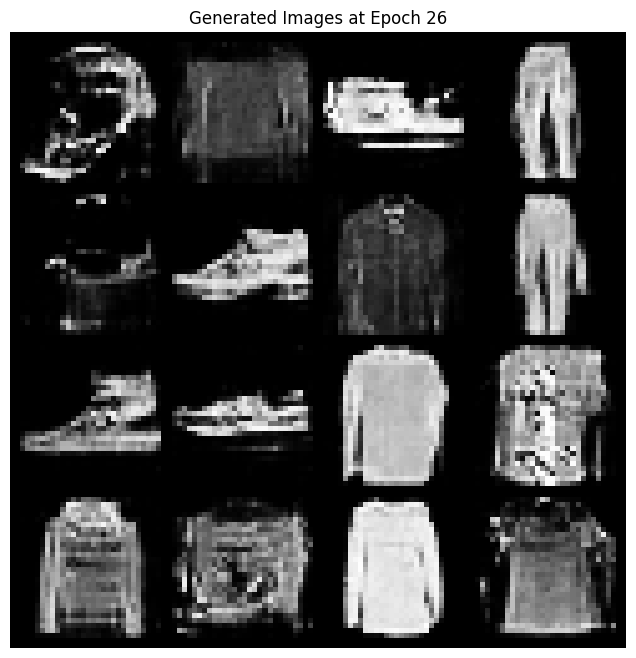

Transformer-GAN Epoch [26/50] Loss D: 0.0011, Loss G: 8.6413


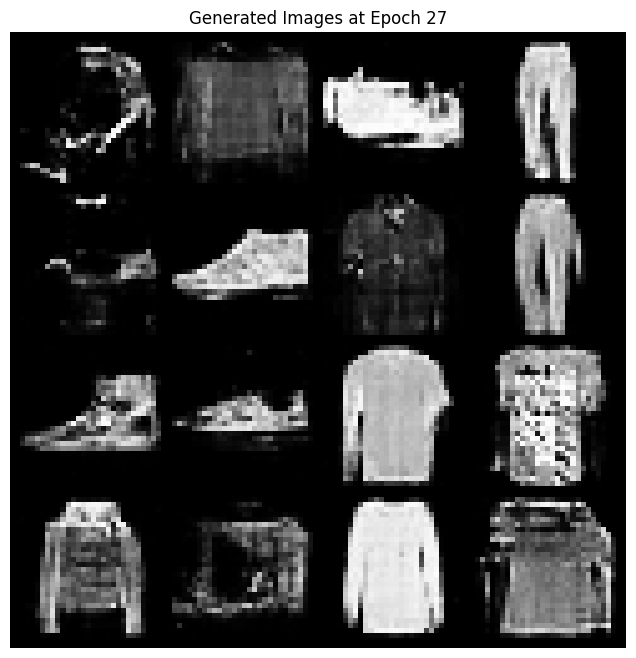

Transformer-GAN Epoch [27/50] Loss D: 0.0016, Loss G: 8.0678


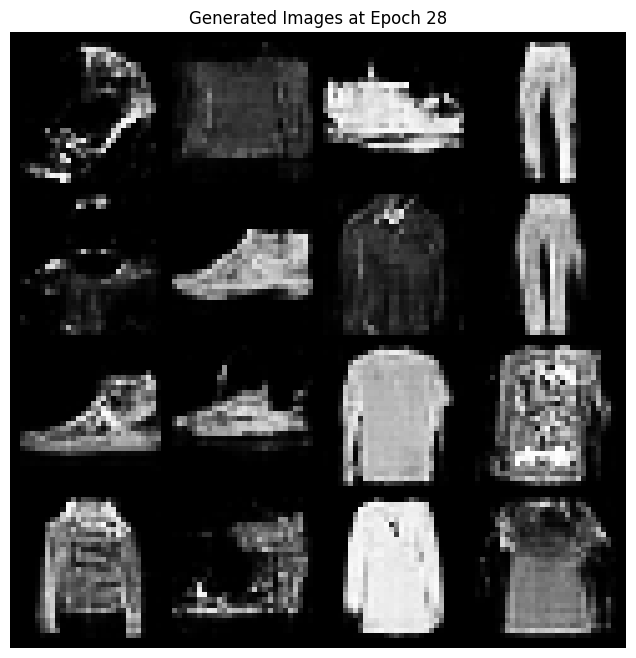

Transformer-GAN Epoch [28/50] Loss D: 0.0038, Loss G: 5.5734


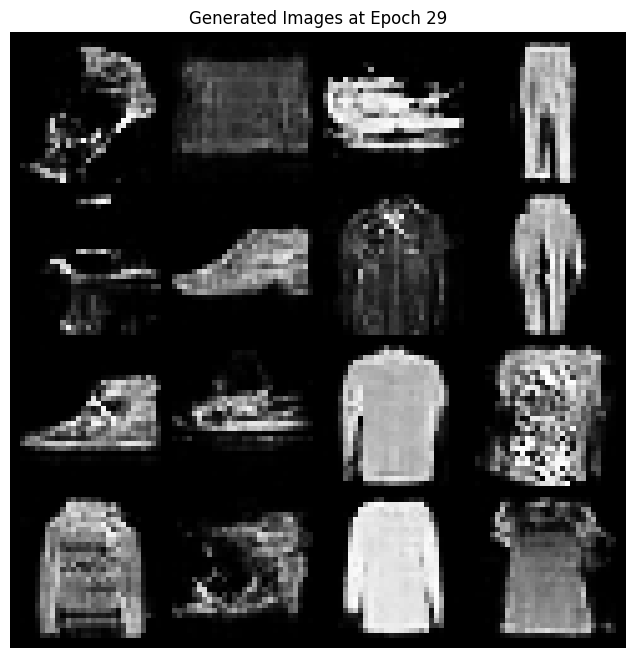

Transformer-GAN Epoch [29/50] Loss D: 0.0026, Loss G: 6.7601


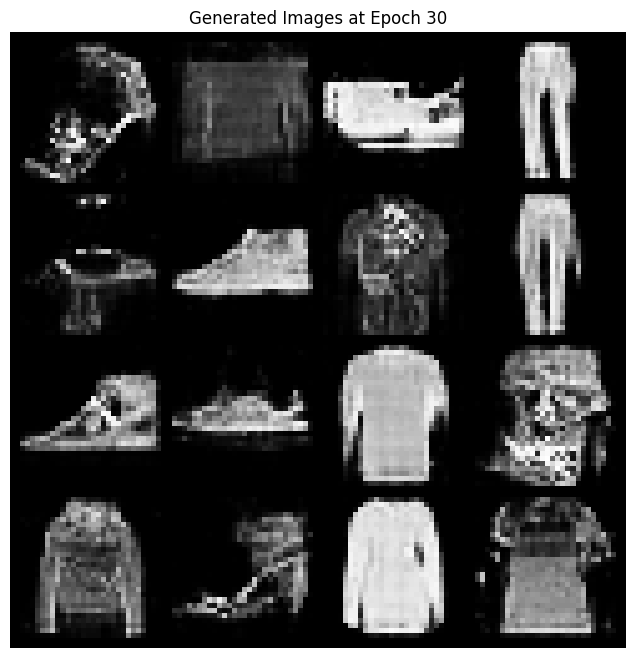

Transformer-GAN Epoch [30/50] Loss D: 0.0059, Loss G: 5.8579


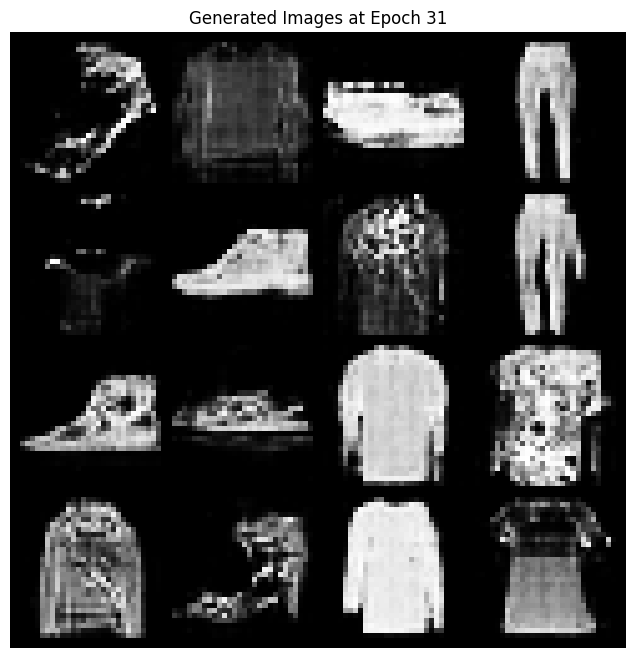

Transformer-GAN Epoch [31/50] Loss D: 0.1840, Loss G: 7.6209


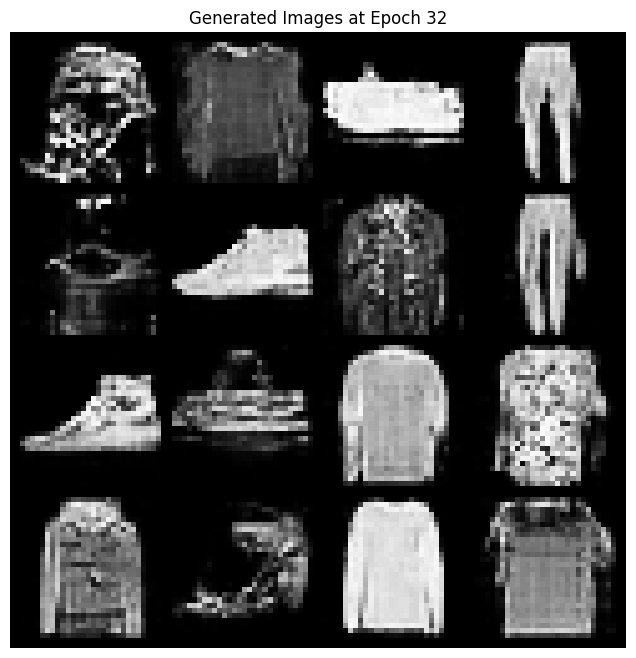

Transformer-GAN Epoch [32/50] Loss D: 0.0067, Loss G: 5.8151


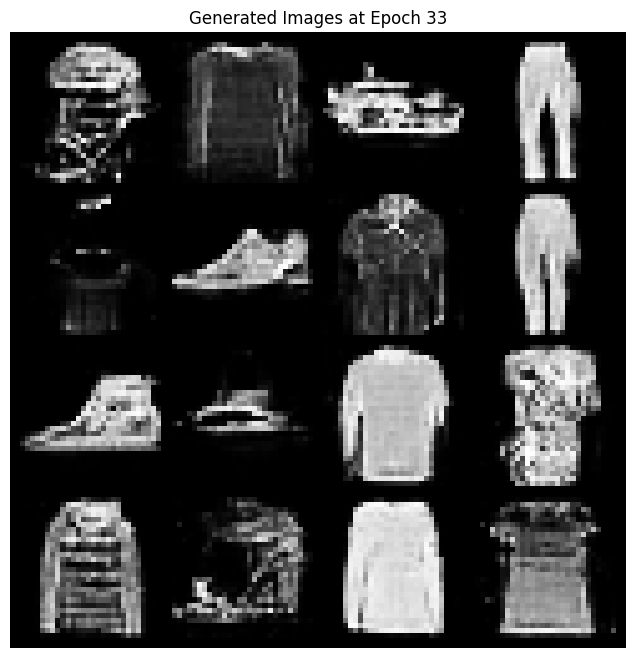

Transformer-GAN Epoch [33/50] Loss D: 0.0036, Loss G: 7.4453


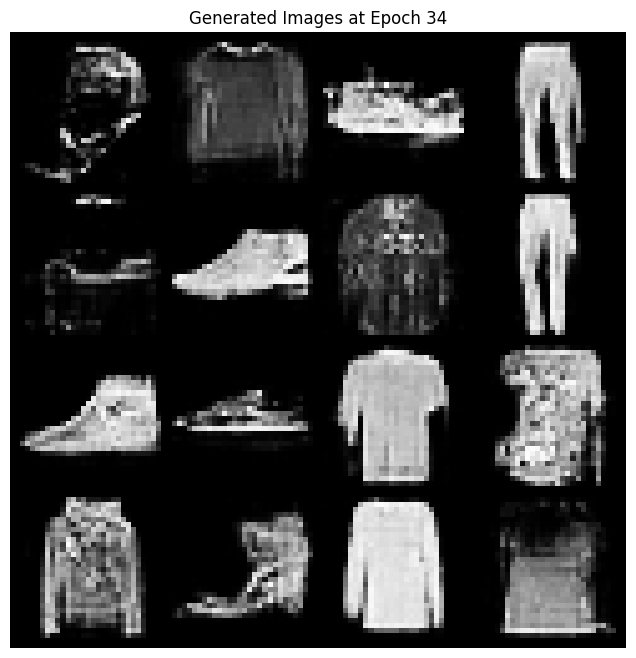

Transformer-GAN Epoch [34/50] Loss D: 0.0042, Loss G: 8.8852


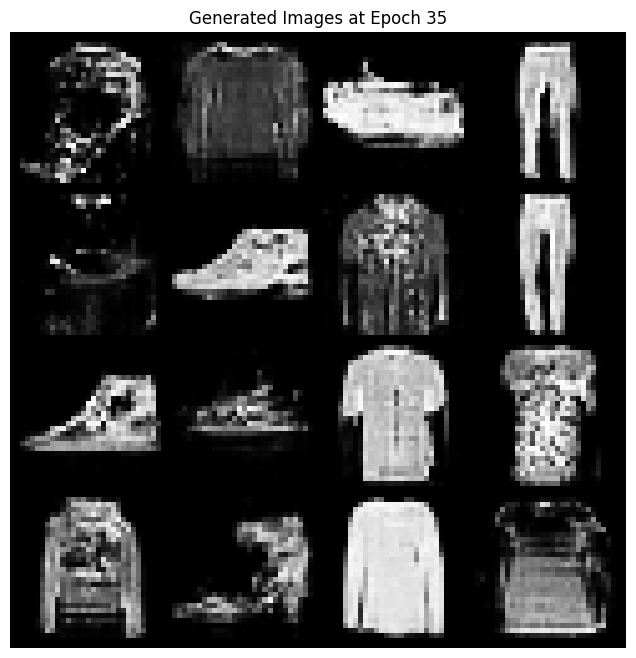

Transformer-GAN Epoch [35/50] Loss D: 0.0199, Loss G: 5.7405


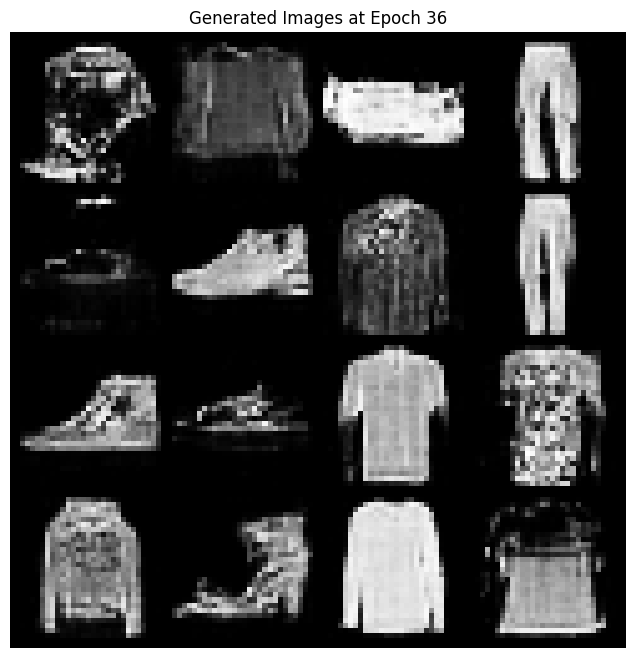

Transformer-GAN Epoch [36/50] Loss D: 0.0085, Loss G: 6.3814


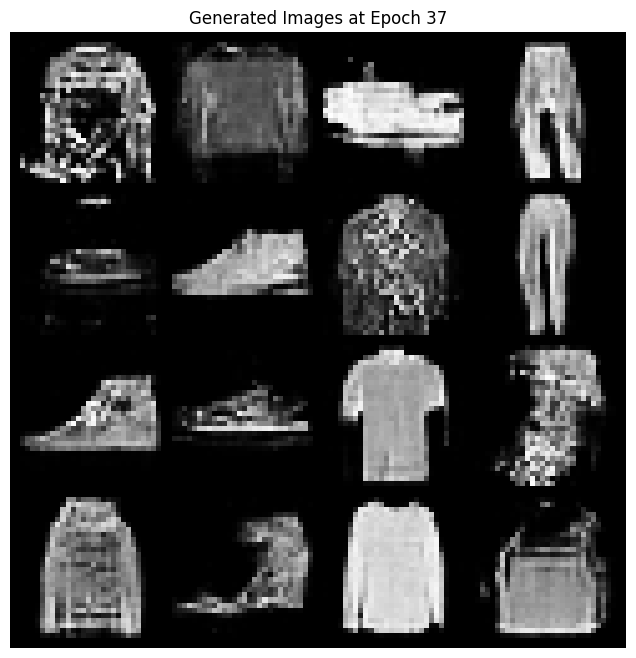

Transformer-GAN Epoch [37/50] Loss D: 0.0018, Loss G: 6.9531


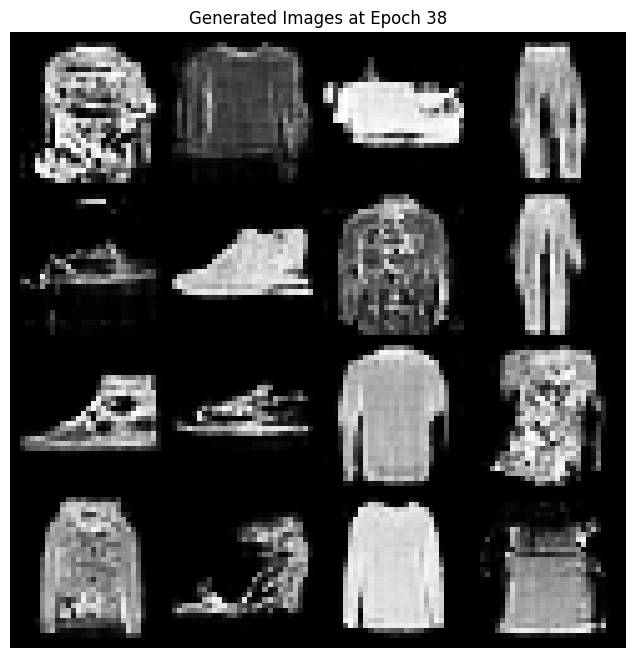

Transformer-GAN Epoch [38/50] Loss D: 0.0075, Loss G: 7.5638


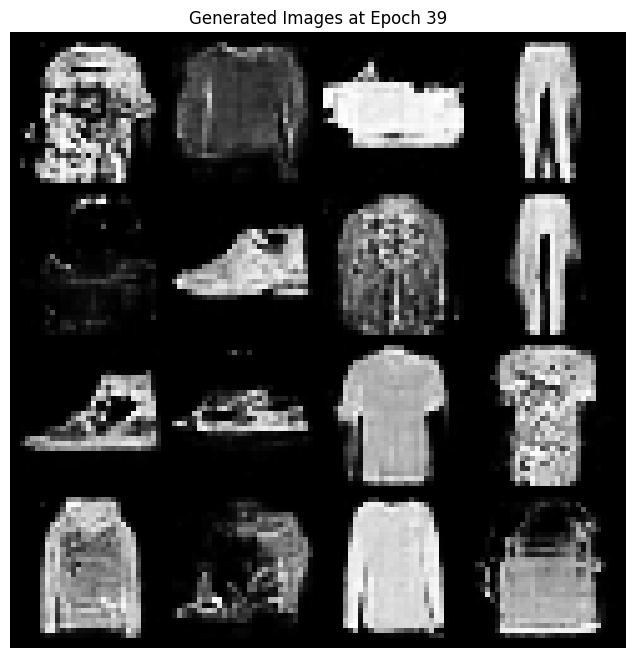

Transformer-GAN Epoch [39/50] Loss D: 0.0071, Loss G: 8.6670


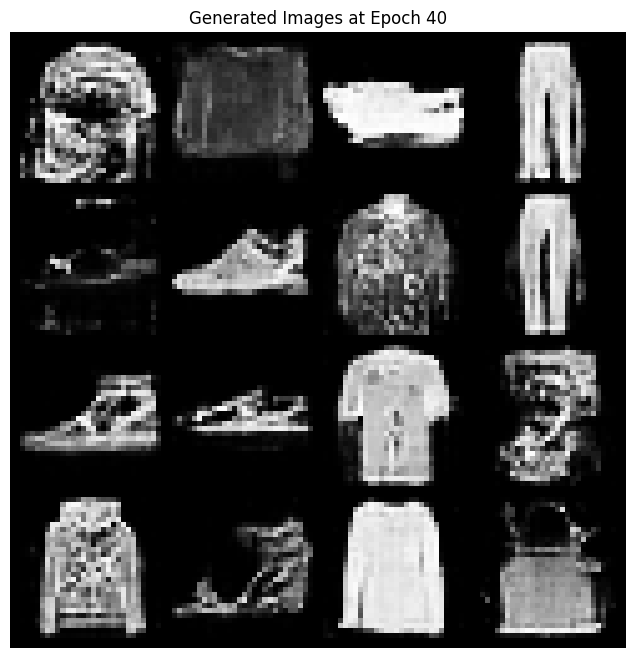

Transformer-GAN Epoch [40/50] Loss D: 0.0436, Loss G: 4.2711


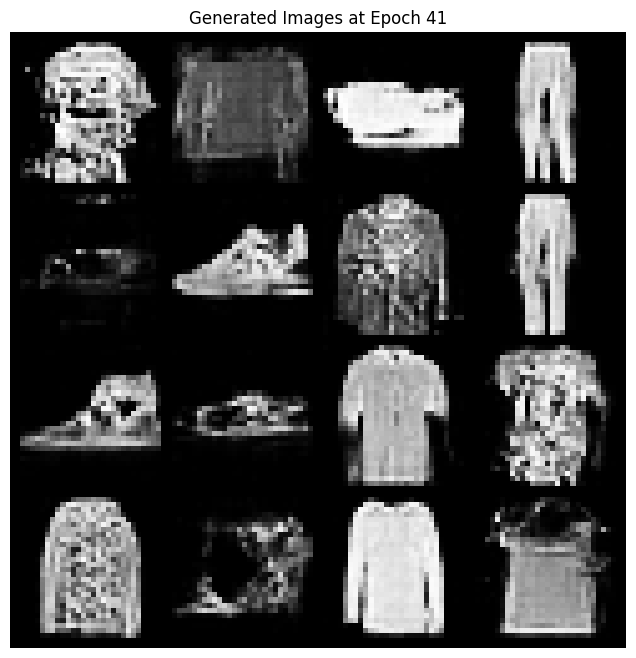

Transformer-GAN Epoch [41/50] Loss D: 0.0303, Loss G: 5.4580


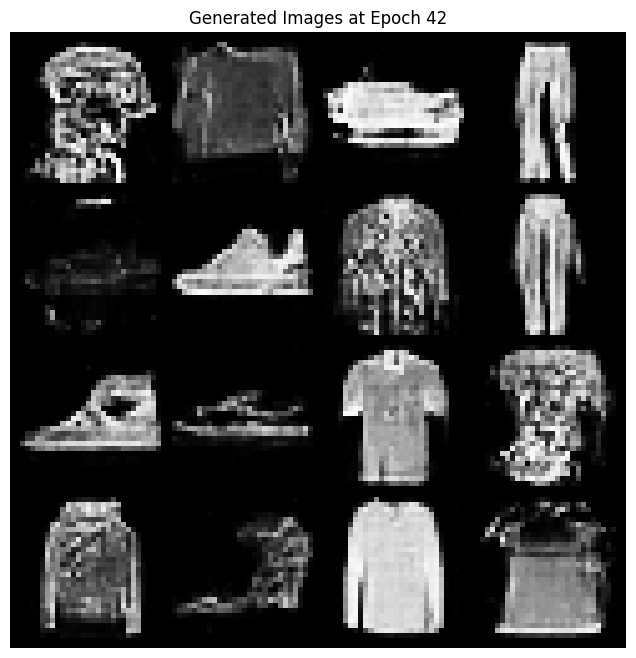

Transformer-GAN Epoch [42/50] Loss D: 0.0116, Loss G: 6.7731


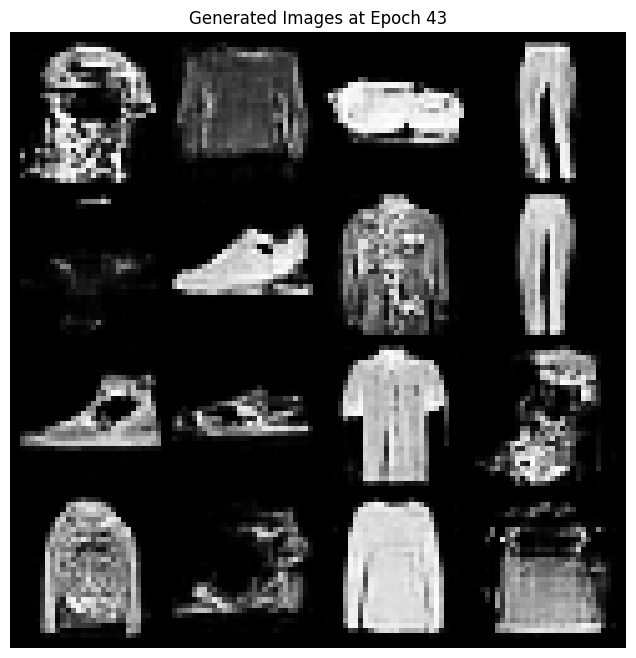

Transformer-GAN Epoch [43/50] Loss D: 0.0023, Loss G: 9.1936


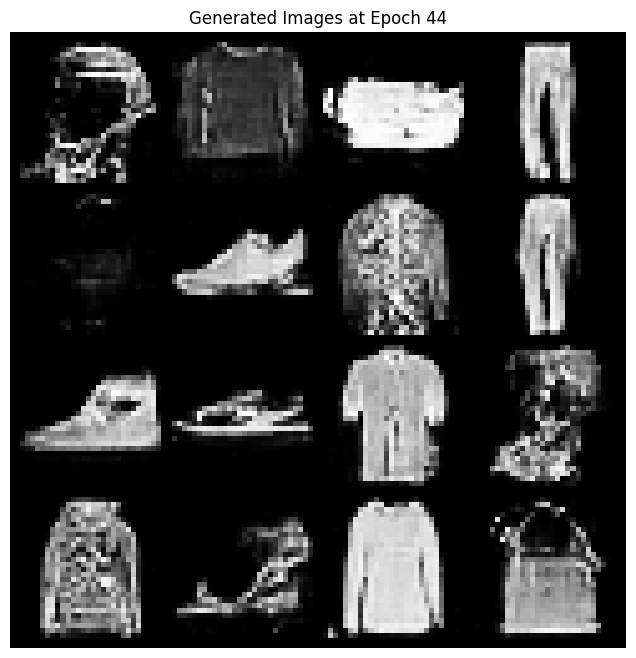

Transformer-GAN Epoch [44/50] Loss D: 0.0320, Loss G: 6.5102


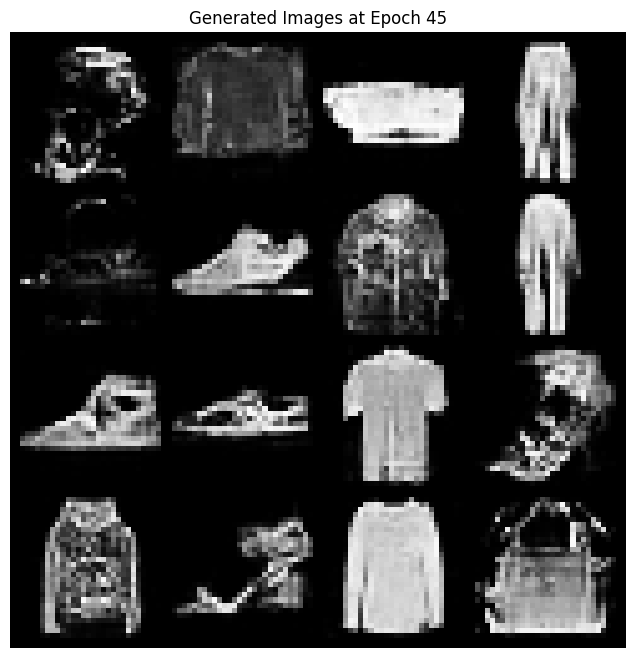

Transformer-GAN Epoch [45/50] Loss D: 0.0107, Loss G: 5.6632


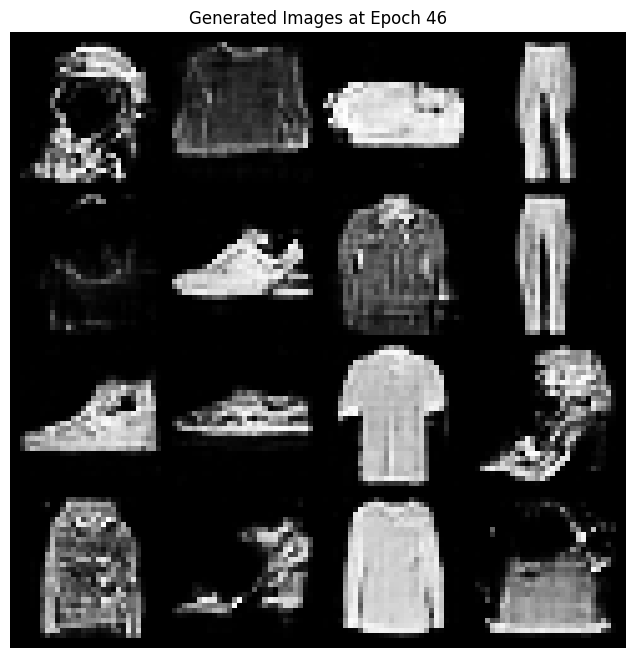

Transformer-GAN Epoch [46/50] Loss D: 0.0985, Loss G: 7.7248


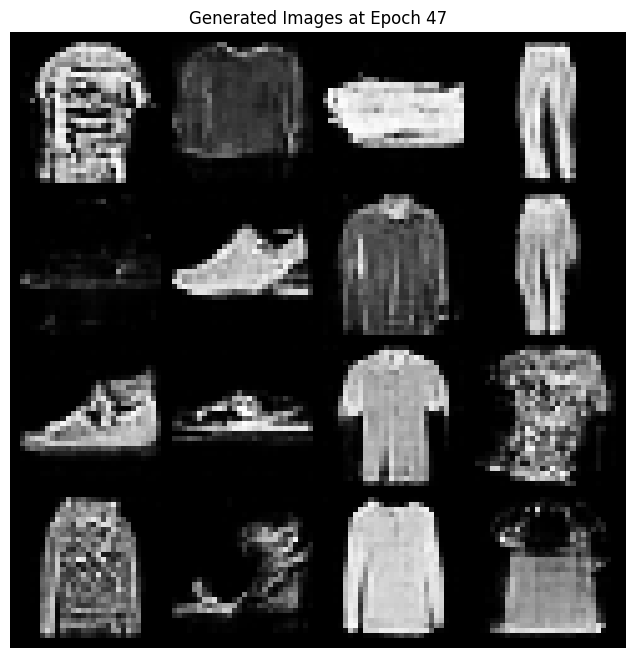

Transformer-GAN Epoch [47/50] Loss D: 0.0365, Loss G: 5.9465


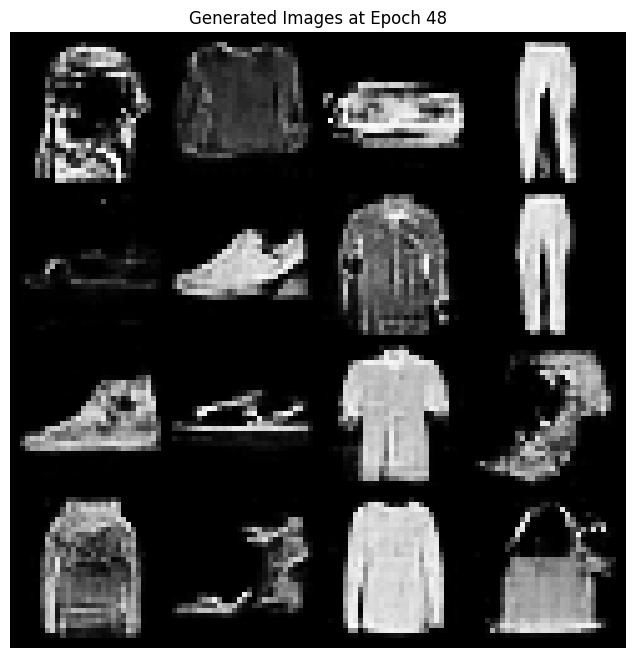

Transformer-GAN Epoch [48/50] Loss D: 0.0061, Loss G: 6.4337


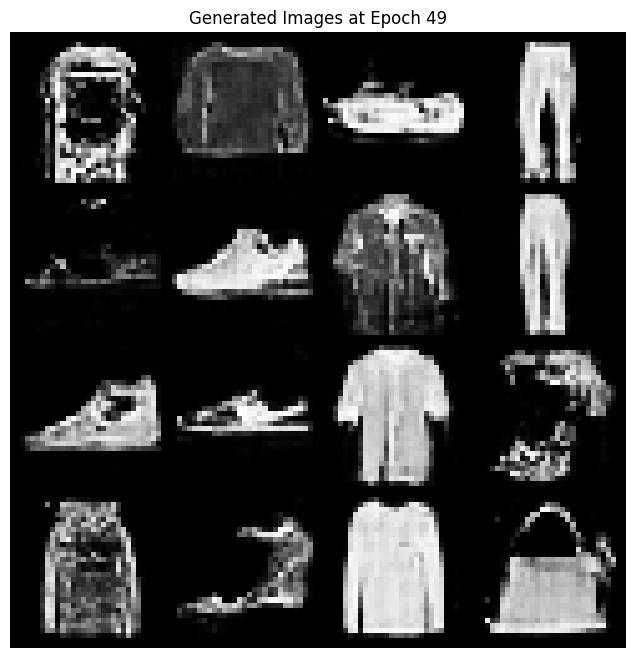

Transformer-GAN Epoch [49/50] Loss D: 0.0018, Loss G: 8.5915


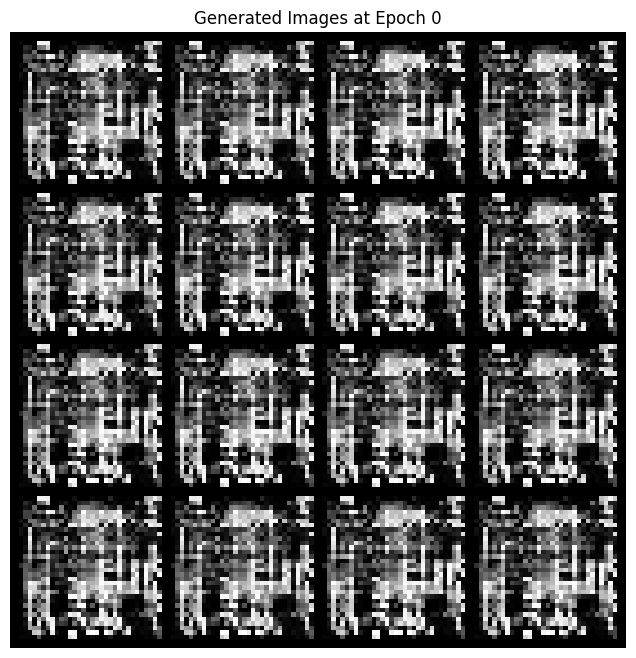

DCGAN Epoch [0/50] Loss D: 0.0004, Loss G: 7.6435


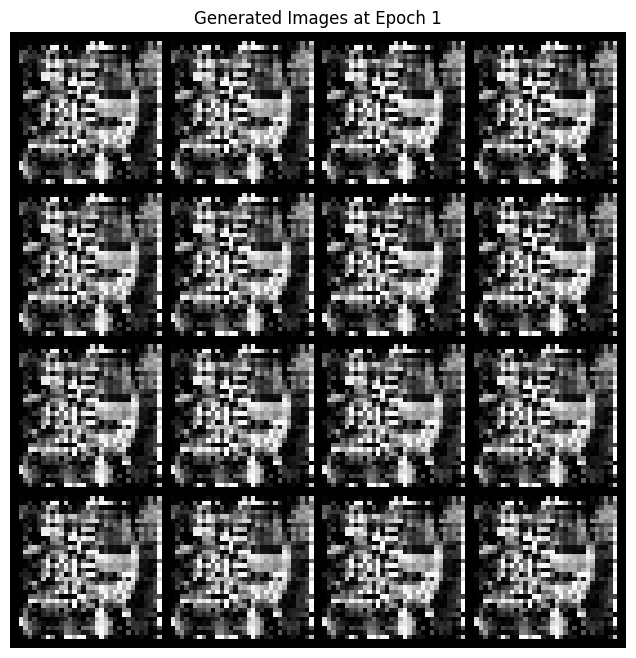

DCGAN Epoch [1/50] Loss D: 0.0002, Loss G: 9.6893


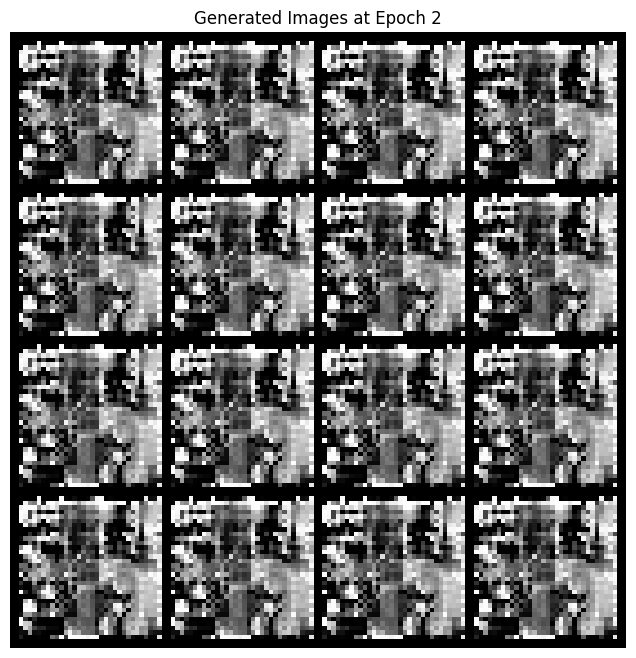

DCGAN Epoch [2/50] Loss D: 0.0000, Loss G: 10.7241


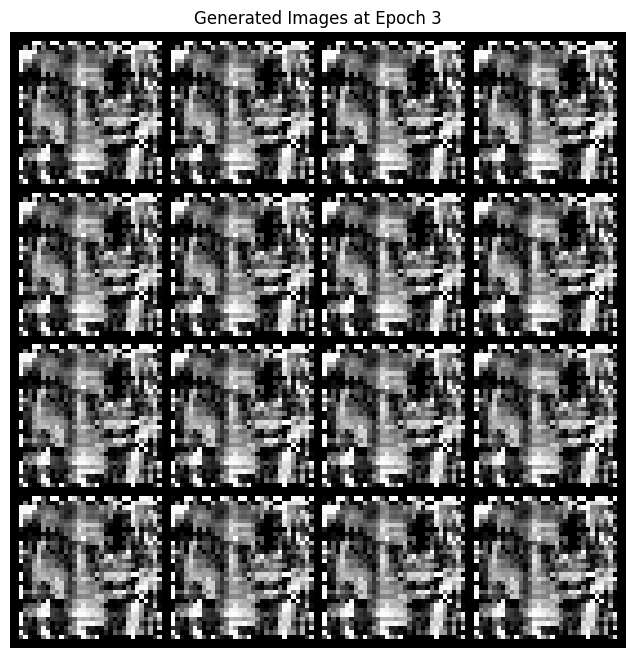

DCGAN Epoch [3/50] Loss D: 0.0000, Loss G: 11.0259


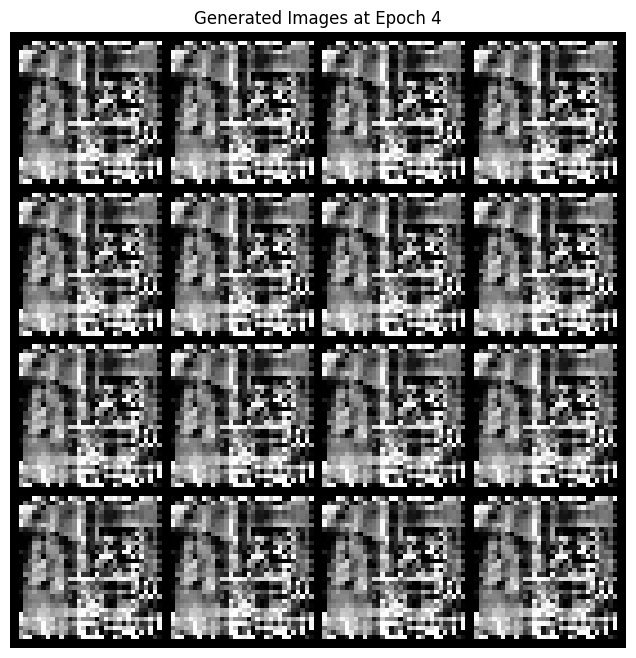

DCGAN Epoch [4/50] Loss D: 0.0000, Loss G: 12.1860


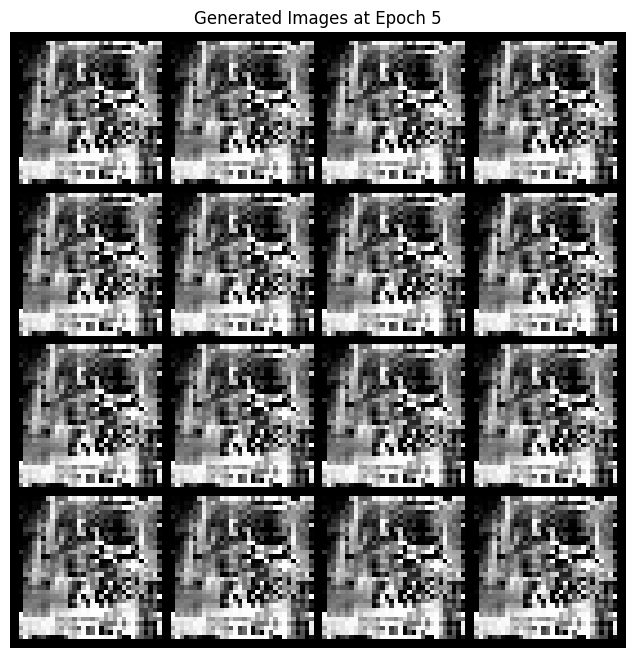

DCGAN Epoch [5/50] Loss D: 0.0000, Loss G: 12.7223


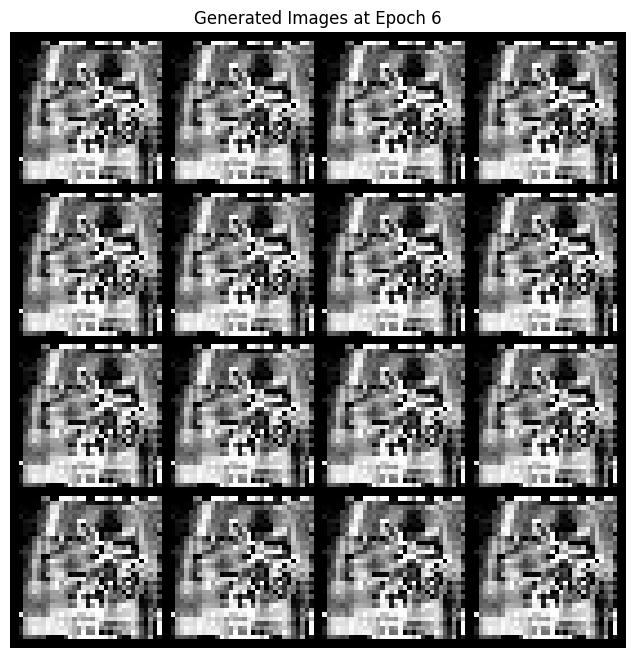

DCGAN Epoch [6/50] Loss D: 0.0000, Loss G: 13.9911


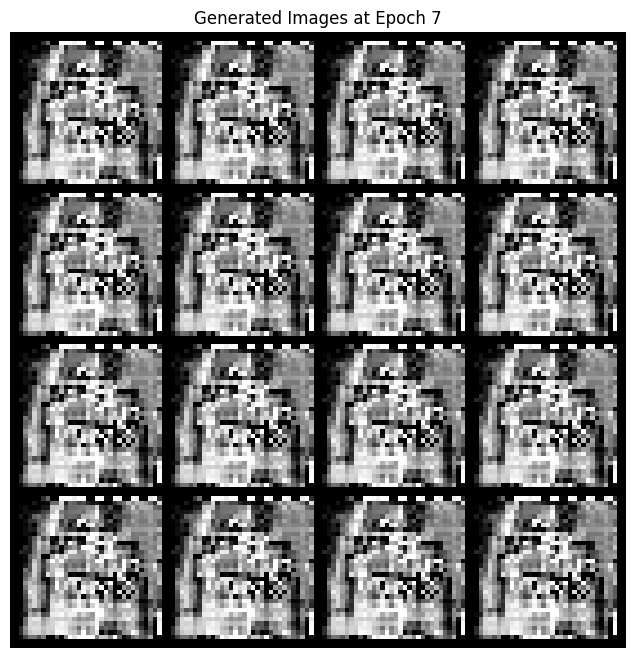

DCGAN Epoch [7/50] Loss D: 0.0000, Loss G: 13.9319


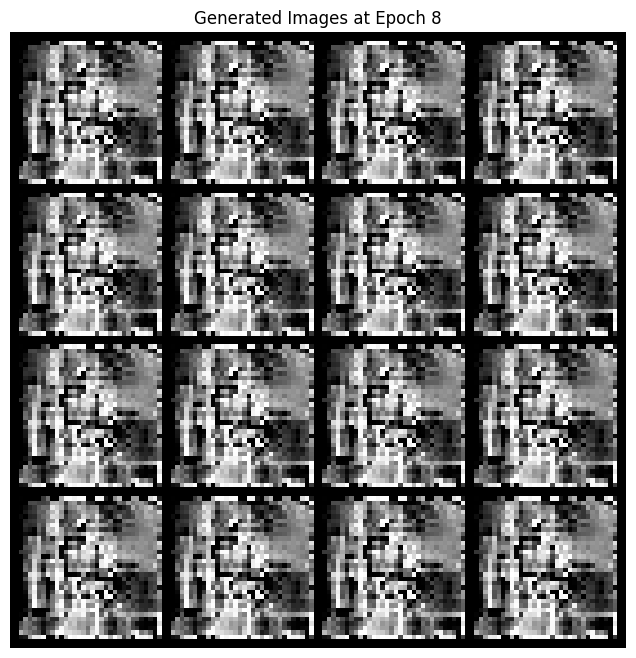

DCGAN Epoch [8/50] Loss D: 0.0000, Loss G: 13.9361


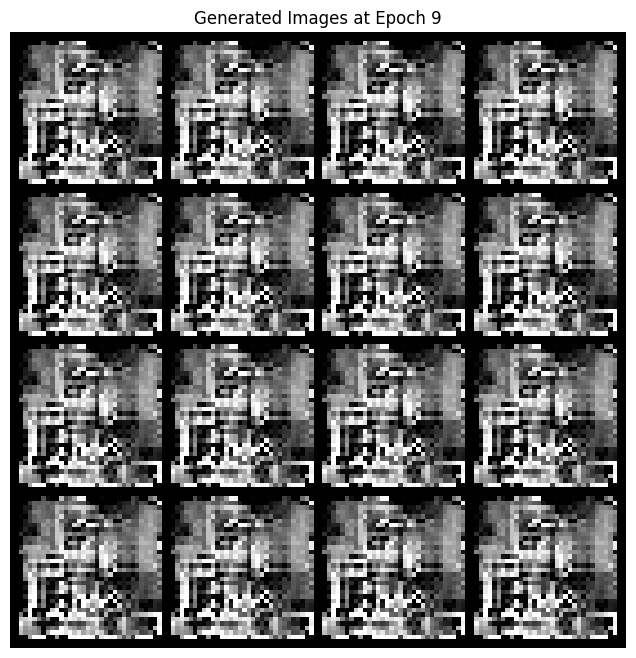

DCGAN Epoch [9/50] Loss D: 0.0000, Loss G: 14.3979


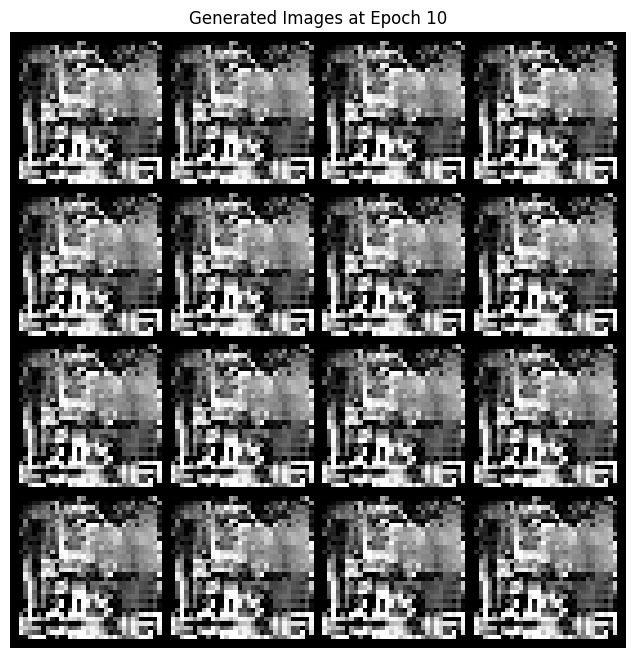

DCGAN Epoch [10/50] Loss D: 0.0000, Loss G: 14.4536


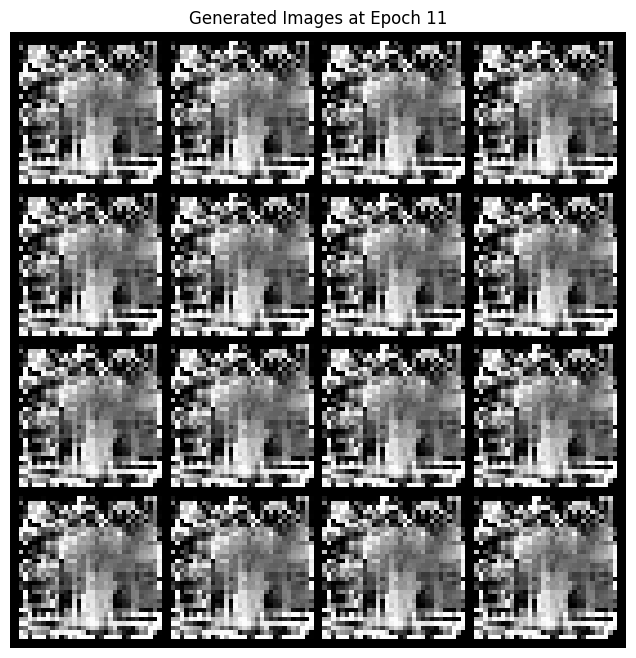

DCGAN Epoch [11/50] Loss D: 0.0000, Loss G: 15.5659


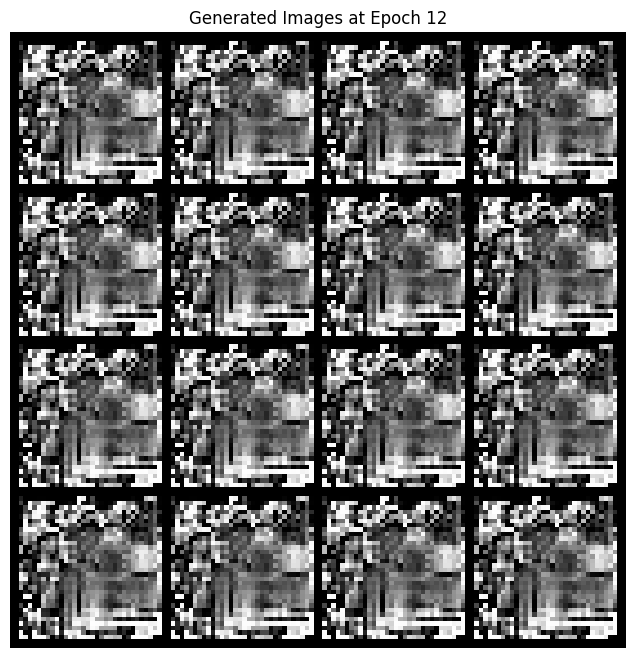

DCGAN Epoch [12/50] Loss D: 0.0000, Loss G: 16.6405


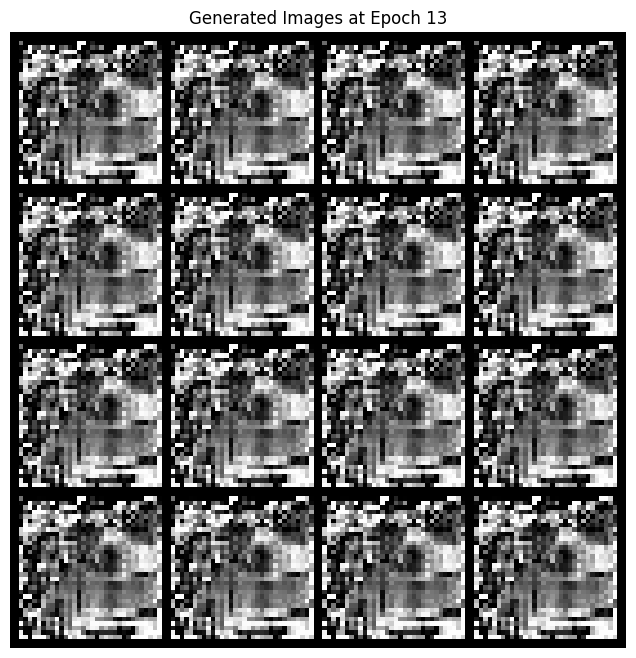

DCGAN Epoch [13/50] Loss D: 0.0000, Loss G: 17.2747


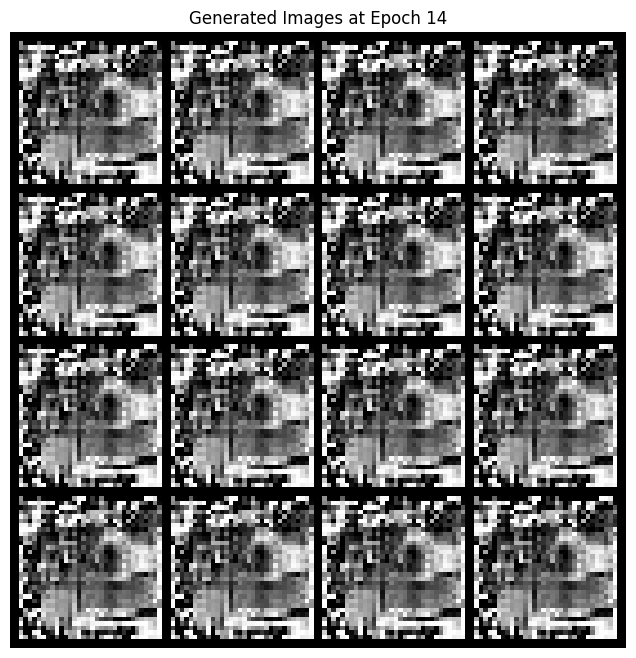

DCGAN Epoch [14/50] Loss D: 0.0000, Loss G: 17.7274


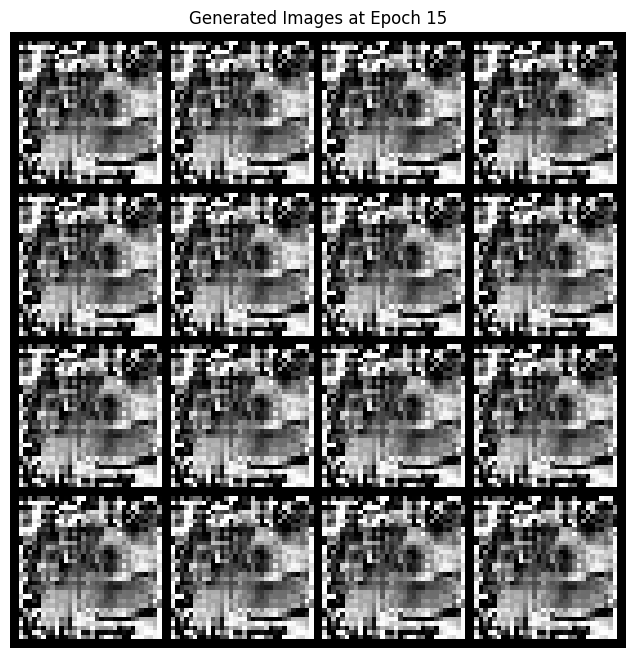

DCGAN Epoch [15/50] Loss D: 0.0000, Loss G: 18.9962


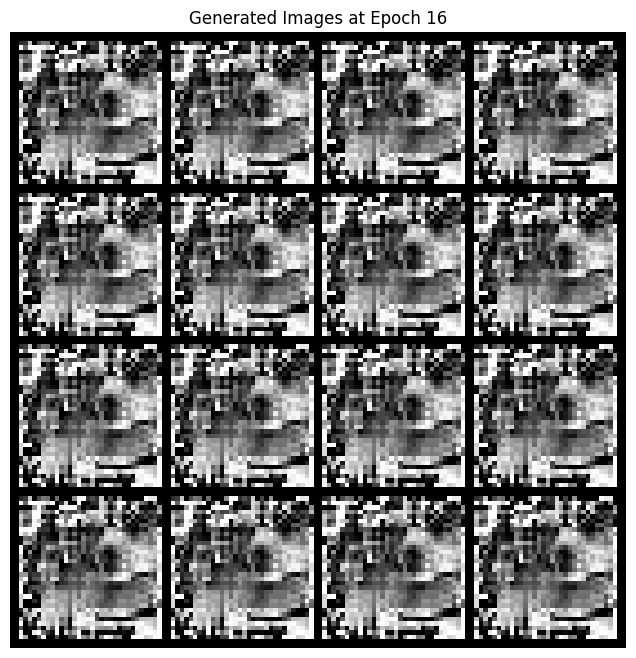

DCGAN Epoch [16/50] Loss D: 0.0000, Loss G: 19.8392


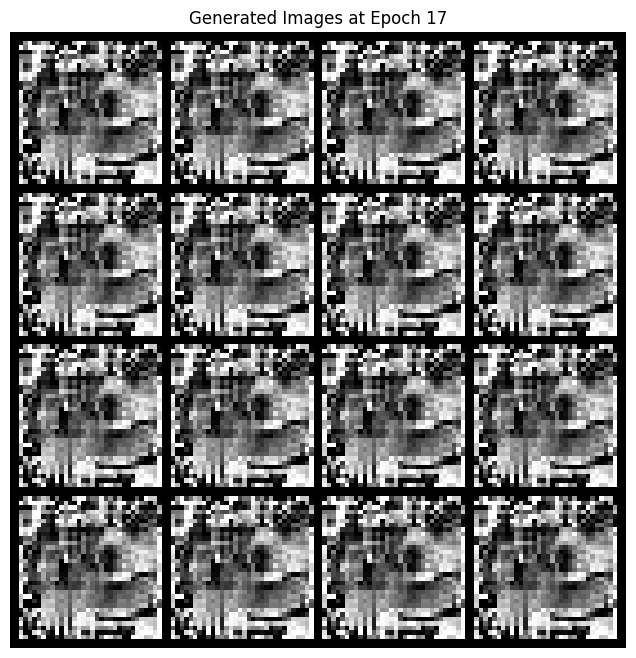

DCGAN Epoch [17/50] Loss D: 0.0000, Loss G: 20.2159


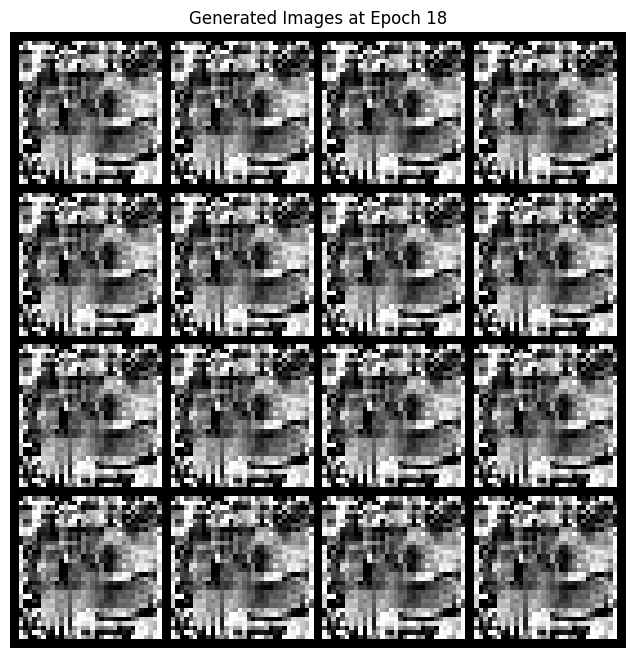

DCGAN Epoch [18/50] Loss D: 0.0000, Loss G: 20.9415


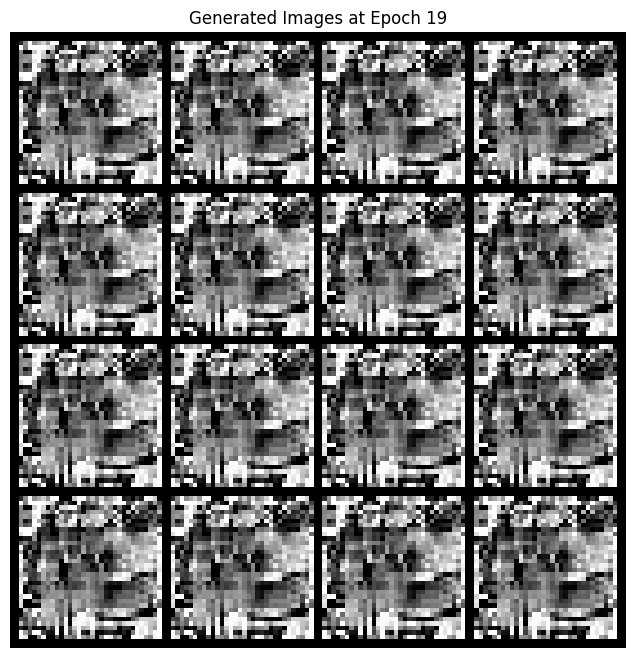

DCGAN Epoch [19/50] Loss D: 0.0000, Loss G: 21.0276


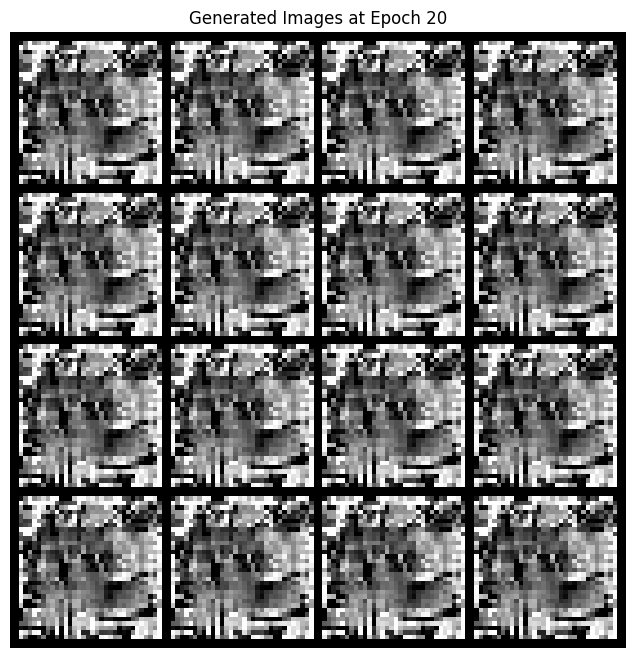

DCGAN Epoch [20/50] Loss D: 0.0000, Loss G: 21.0007


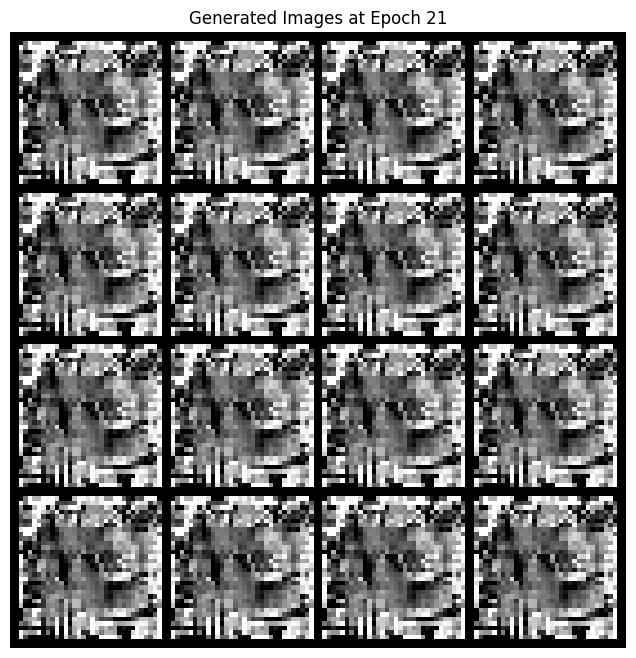

DCGAN Epoch [21/50] Loss D: 0.0000, Loss G: 21.6251


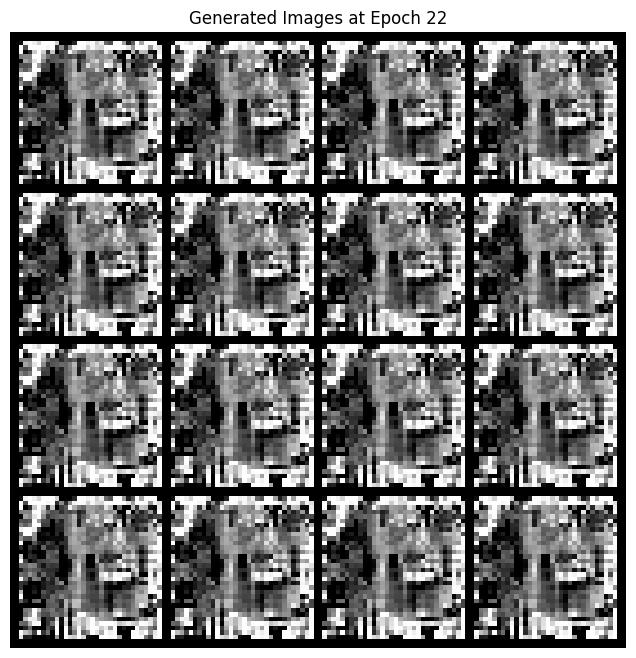

DCGAN Epoch [22/50] Loss D: 0.0000, Loss G: 20.4890


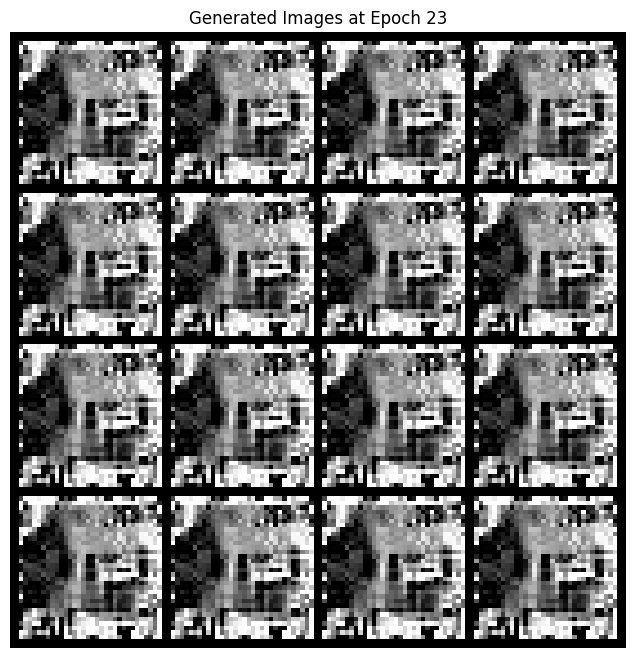

DCGAN Epoch [23/50] Loss D: 0.0000, Loss G: 21.4229


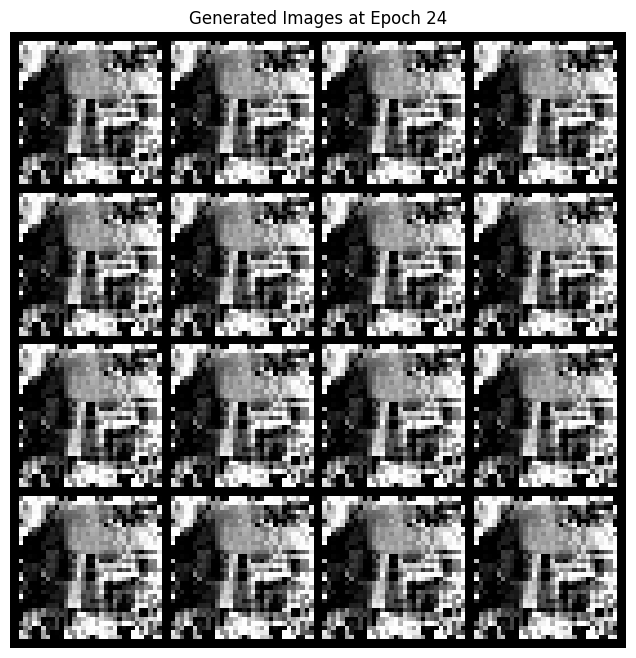

DCGAN Epoch [24/50] Loss D: 0.0000, Loss G: 21.4973


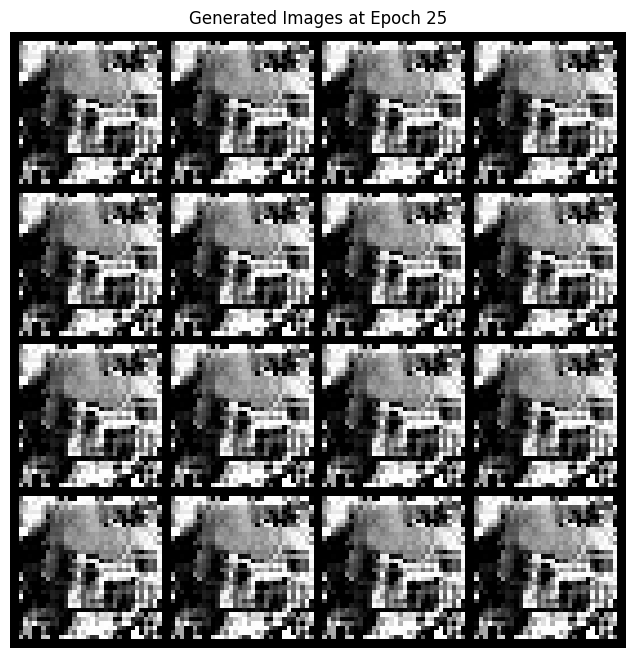

DCGAN Epoch [25/50] Loss D: 0.0000, Loss G: 21.9762


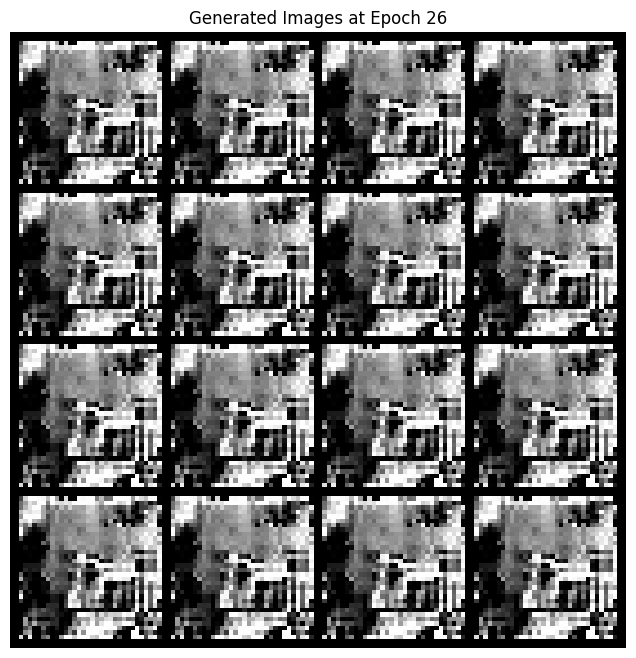

DCGAN Epoch [26/50] Loss D: 0.0000, Loss G: 22.1675


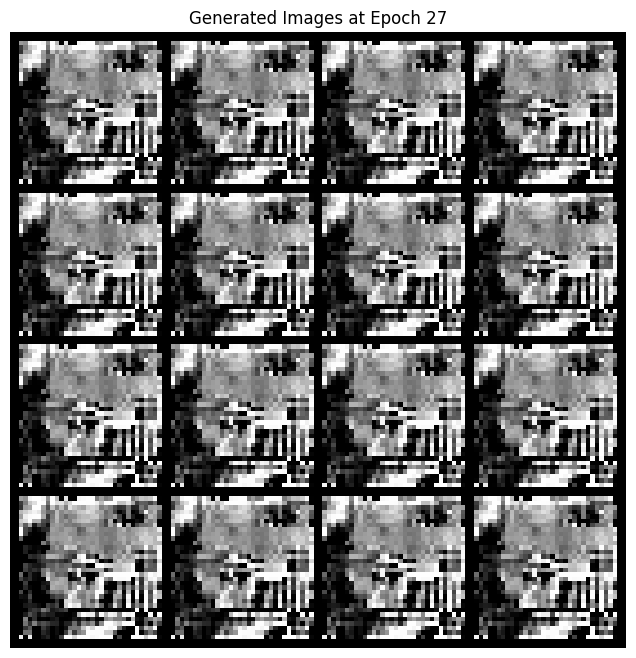

DCGAN Epoch [27/50] Loss D: 0.0000, Loss G: 22.3966


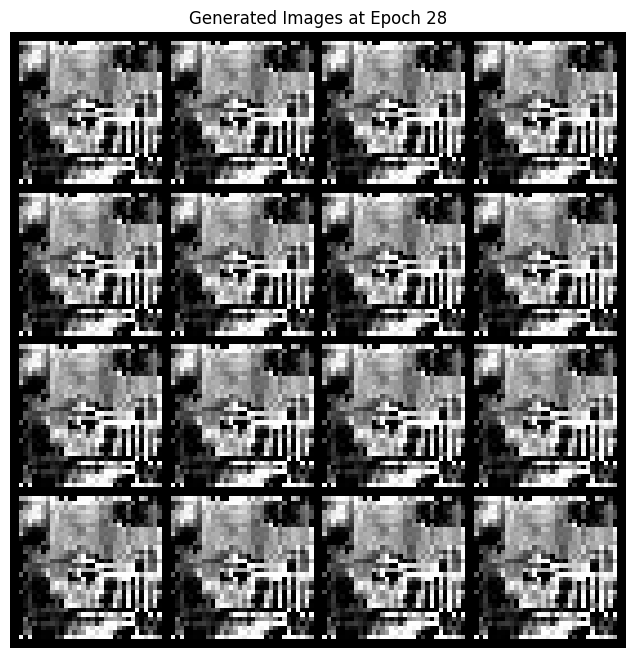

DCGAN Epoch [28/50] Loss D: 0.0000, Loss G: 22.9633


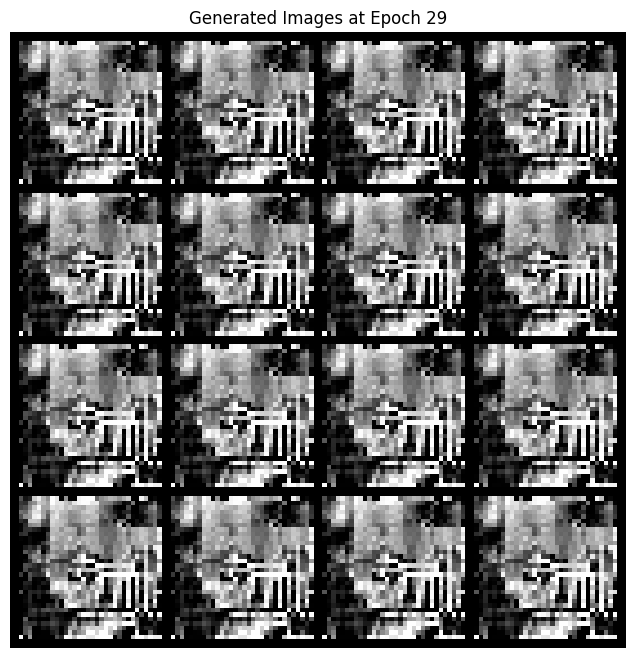

DCGAN Epoch [29/50] Loss D: 0.0000, Loss G: 23.4500


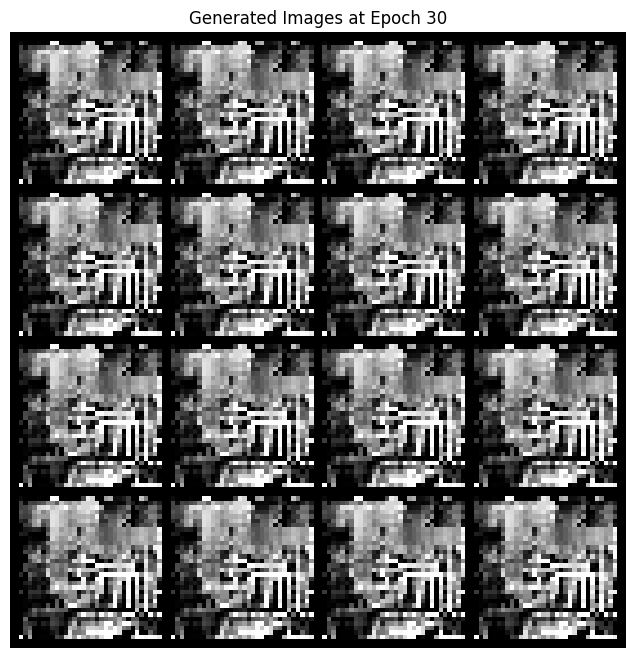

DCGAN Epoch [30/50] Loss D: 0.0000, Loss G: 23.4336


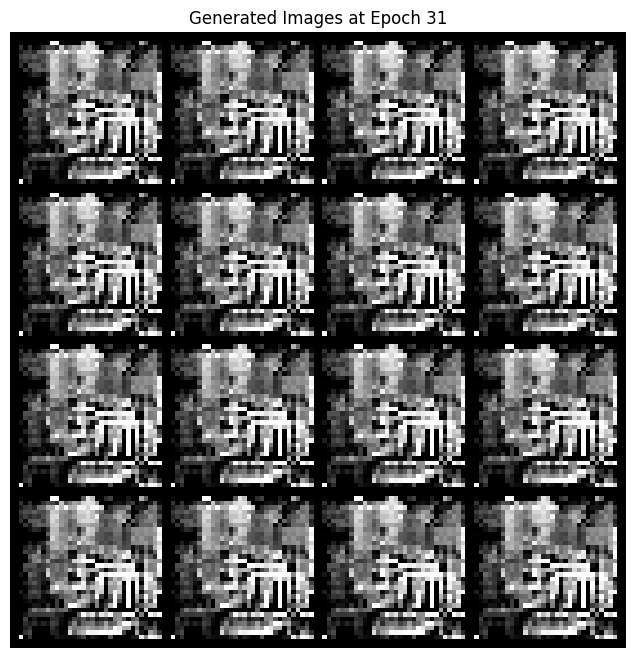

DCGAN Epoch [31/50] Loss D: 0.0000, Loss G: 23.3185


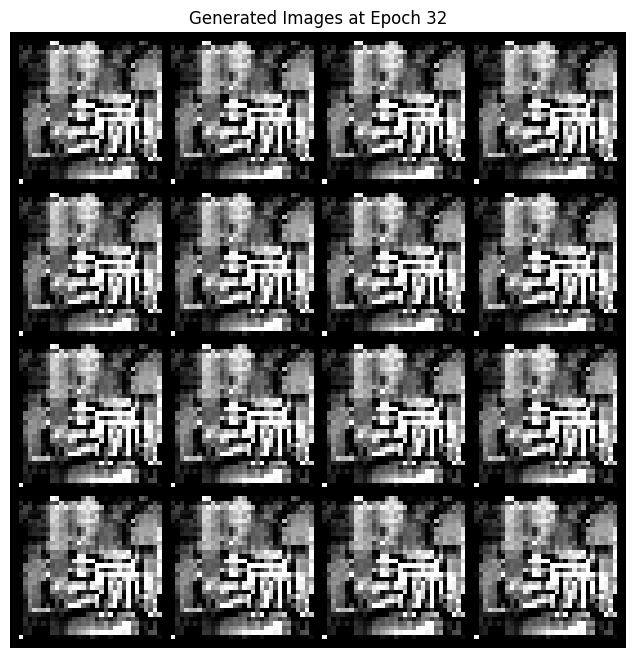

DCGAN Epoch [32/50] Loss D: 0.0000, Loss G: 23.5880


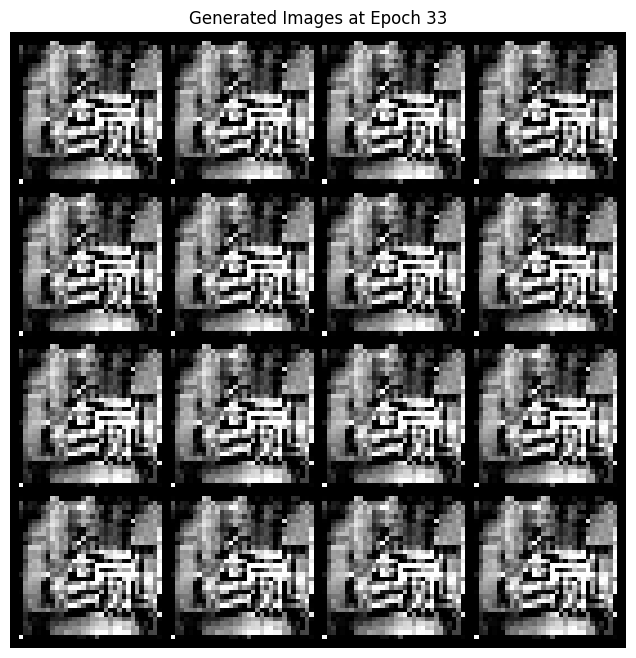

DCGAN Epoch [33/50] Loss D: 0.0000, Loss G: 23.3256


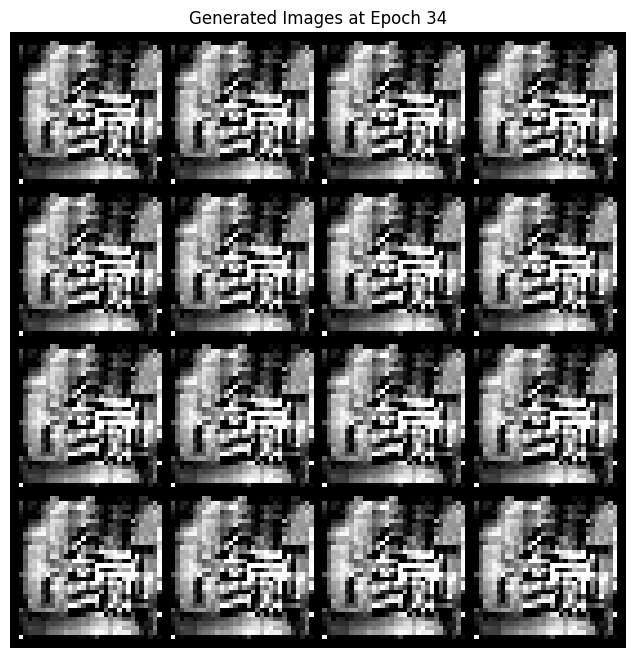

DCGAN Epoch [34/50] Loss D: 0.0000, Loss G: 24.2070


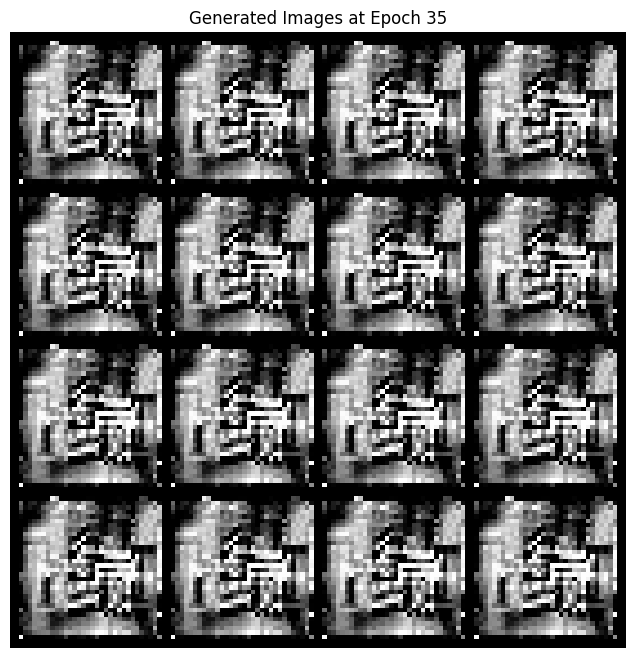

DCGAN Epoch [35/50] Loss D: 0.0000, Loss G: 24.0700


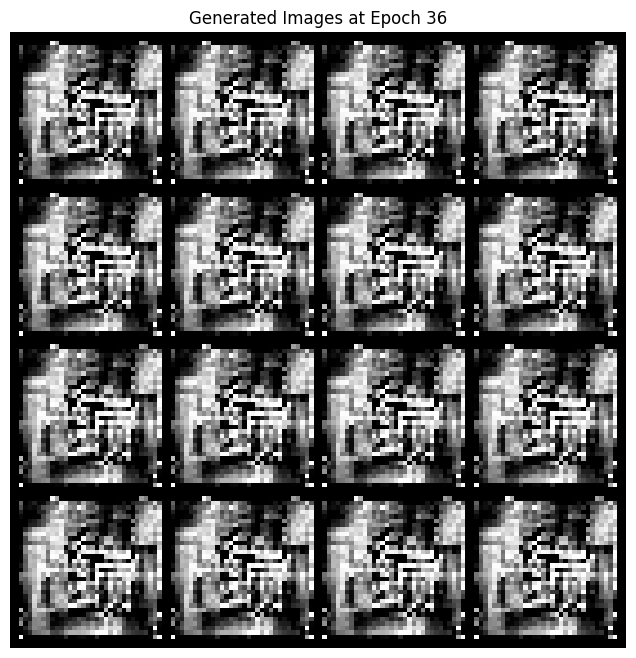

DCGAN Epoch [36/50] Loss D: 0.0000, Loss G: 24.0568


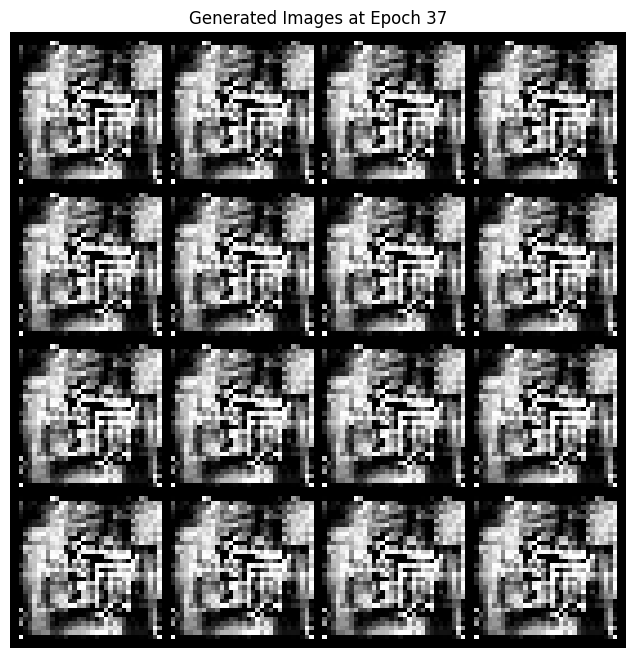

DCGAN Epoch [37/50] Loss D: 0.0000, Loss G: 24.2150


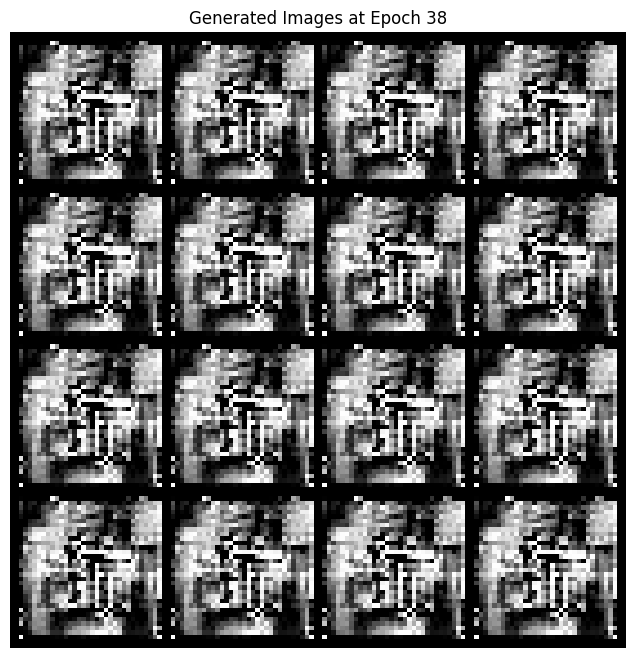

DCGAN Epoch [38/50] Loss D: 0.0000, Loss G: 24.2691


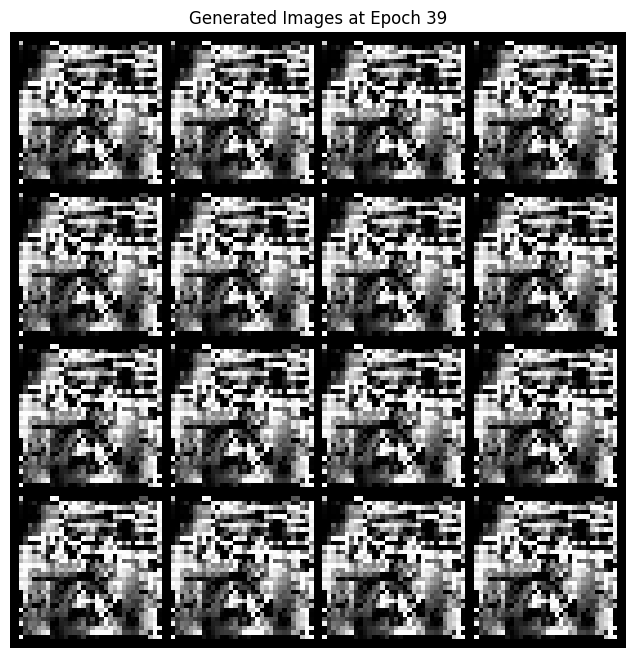

DCGAN Epoch [39/50] Loss D: 0.0000, Loss G: 36.5905


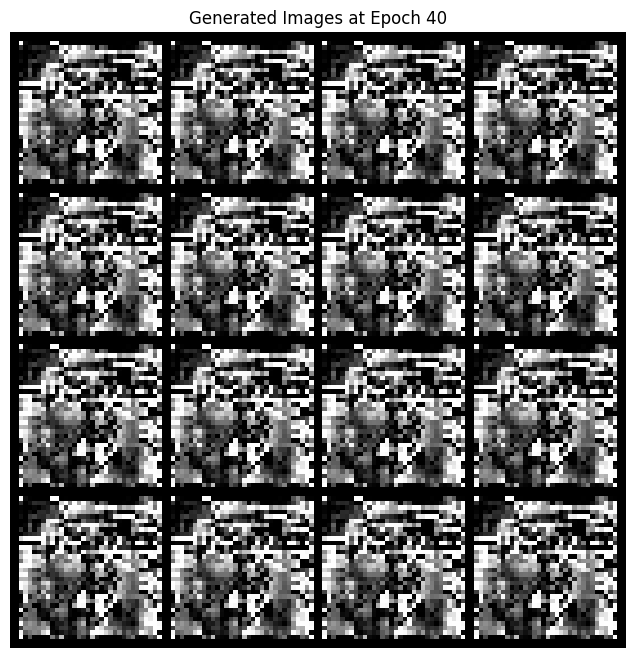

DCGAN Epoch [40/50] Loss D: 0.0000, Loss G: 36.6637


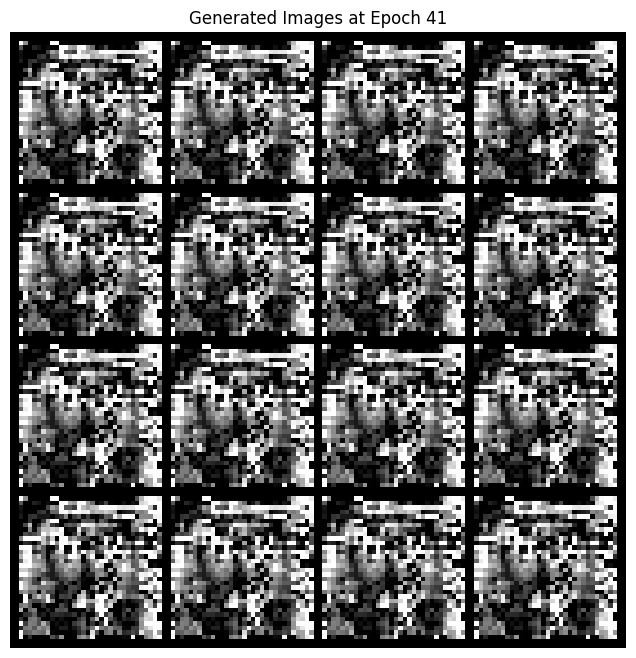

DCGAN Epoch [41/50] Loss D: 0.0000, Loss G: 39.6557


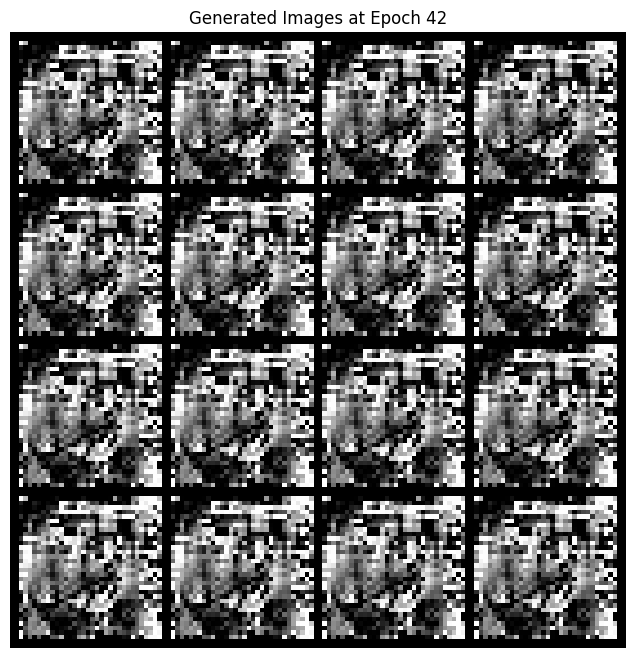

DCGAN Epoch [42/50] Loss D: 0.0000, Loss G: 39.0394


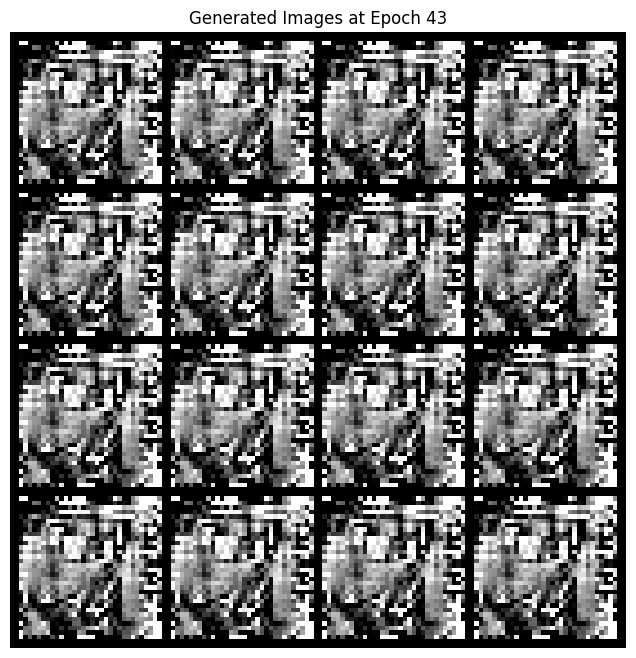

DCGAN Epoch [43/50] Loss D: 0.0000, Loss G: 42.0678


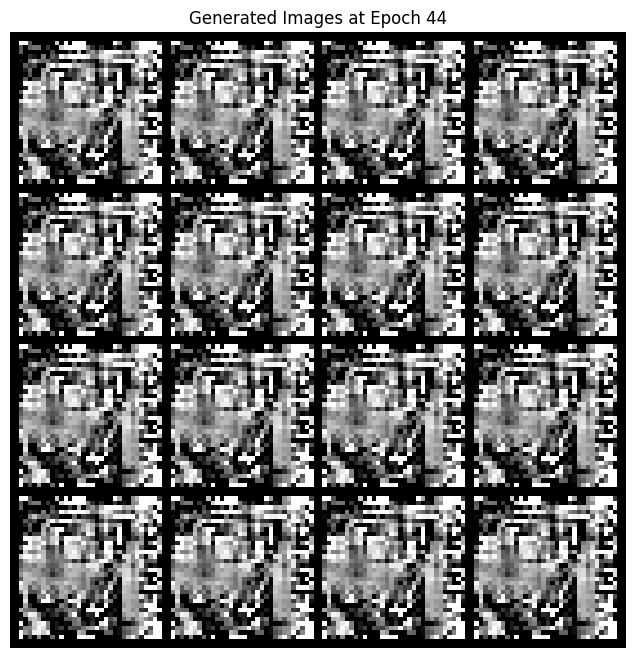

DCGAN Epoch [44/50] Loss D: 0.0000, Loss G: 42.9311


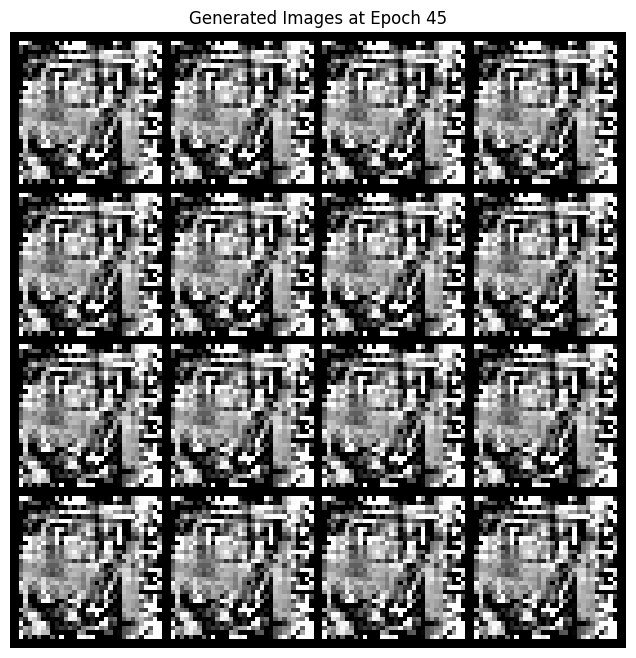

DCGAN Epoch [45/50] Loss D: 0.0000, Loss G: 43.4107


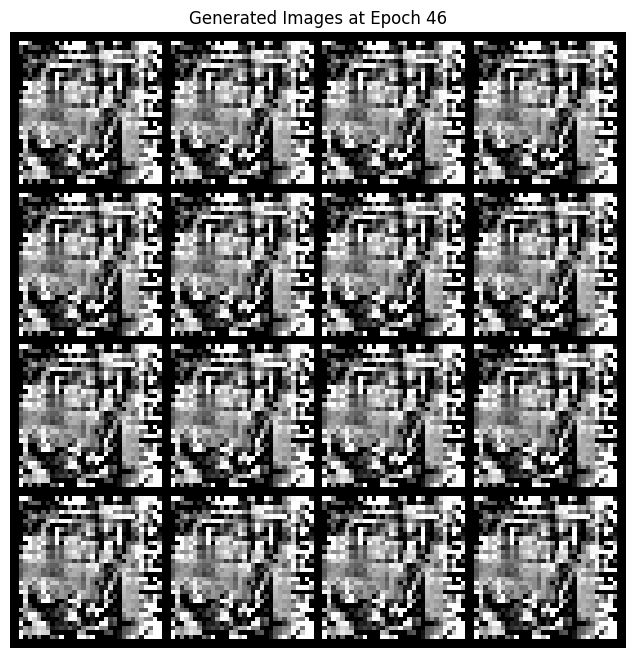

DCGAN Epoch [46/50] Loss D: 0.0000, Loss G: 43.3645


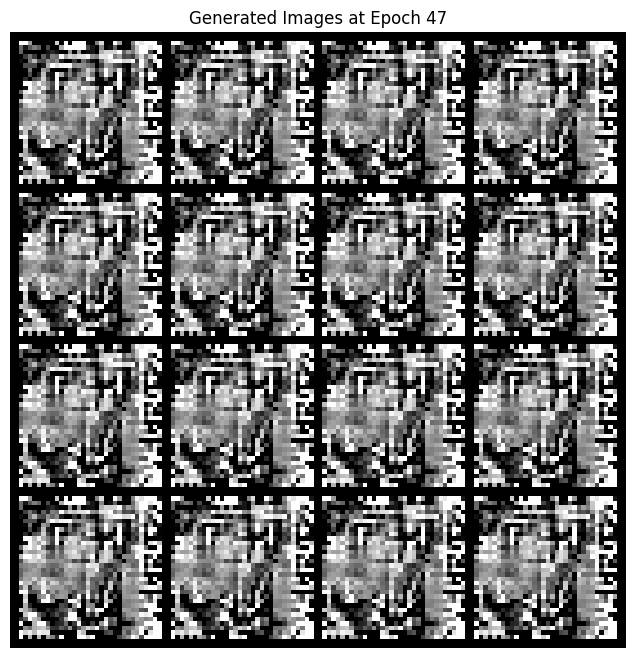

DCGAN Epoch [47/50] Loss D: 0.0000, Loss G: 43.3218


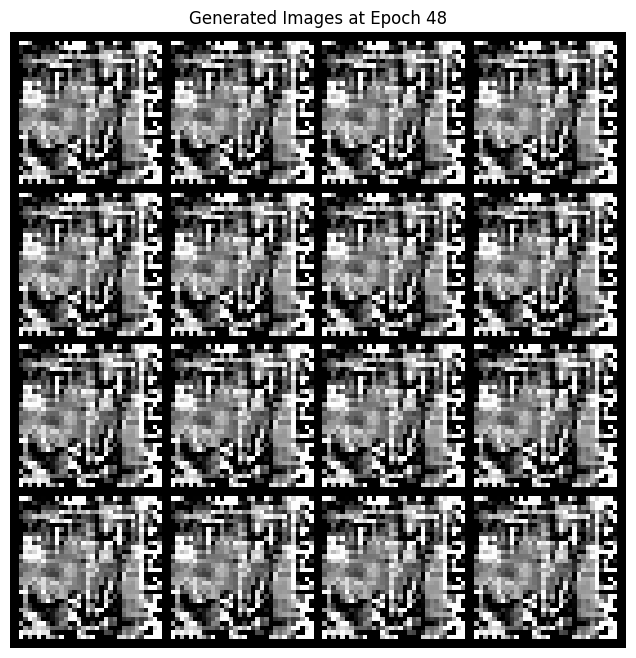

DCGAN Epoch [48/50] Loss D: 0.0000, Loss G: 43.1421


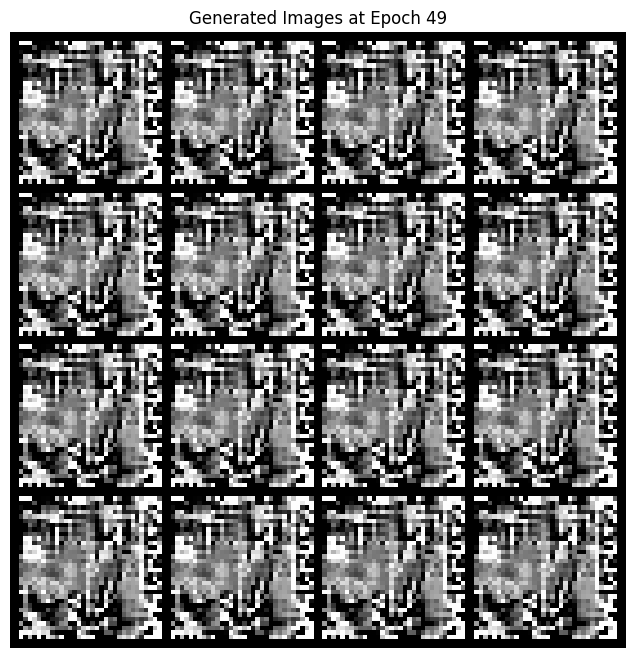

DCGAN Epoch [49/50] Loss D: 0.0000, Loss G: 43.1410


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
Z_DIM = 100
IMG_SIZE = 28
CHANNELS = 1
NUM_EPOCHS = 50
LR = 0.0002

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Inicializar modelos
gen_trans = TransformerGenerator(Z_DIM).to(device)
gen_dcgan = DCGenerator(Z_DIM).to(device)
disc = Discriminator(CHANNELS).to(device)

# Optimizadores
optim_gen_trans = optim.Adam(gen_trans.parameters(), lr=LR, betas=(0.5, 0.999))
optim_gen_dcgan = optim.Adam(gen_dcgan.parameters(), lr=LR, betas=(0.5, 0.999))
optim_disc = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))

# Pérdida
criterion = nn.BCELoss()

# Ruido fijo para visualización
fixed_noise = torch.randn(64, Z_DIM).to(device)

# Directorio para guardar imágenes
os.makedirs("samples_trans", exist_ok=True)
os.makedirs("samples_dcgan", exist_ok=True)

# Entrenamiento para Transformer-GAN
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)
        
        # Entrenar Discriminador
        noise = torch.randn(batch_size, Z_DIM).to(device)
        fake = gen_trans(noise)
        disc_real = disc(real)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach())
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        
        optim_disc.zero_grad()
        loss_disc.backward()
        optim_disc.step()
        
        # Entrenar Generador
        output = disc(fake)
        loss_gen = criterion(output, torch.ones_like(output))
        
        optim_gen_trans.zero_grad()
        loss_gen.backward()
        optim_gen_trans.step()
    
    # Visualización
    visualize_samples(gen_trans, fixed_noise, epoch, save_path="samples_trans")
    print(f"Transformer-GAN Epoch [{epoch}/{NUM_EPOCHS}] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

# Entrenamiento para DCGAN
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)
        
        # Entrenar Discriminador
        noise = torch.randn(batch_size, Z_DIM).to(device)
        fake = gen_dcgan(noise)
        disc_real = disc(real)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach())
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        
        optim_disc.zero_grad()
        loss_disc.backward()
        optim_disc.step()
        
        # Entrenar Generador
        output = disc(fake)
        loss_gen = criterion(output, torch.ones_like(output))
        
        optim_gen_dcgan.zero_grad()
        loss_gen.backward()
        optim_gen_dcgan.step()
    
    # Visualización
    visualize_samples(gen_dcgan, fixed_noise, epoch, save_path="samples_dcgan")
    print(f"DCGAN Epoch [{epoch}/{NUM_EPOCHS}] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

# Uso de atención para generalizar datos sintéticos:

La auto-atención permite modelar relaciones globales, mejora la diversidad de imágenes generadas, en este caso en la coherencia en patrones de ropa complejos

Las matrices de atención pueden visualizarse para entender qué partes de la imagen influyen en otras, pero la interpretación es menos directa que en CNN porque los tokens son abstractos


Transformer-GAN:
    Epochs tempranas: Imágenes borrosas o incoherentes debido a la complejidad del Transformer y la necesidad de más ajuste
    Epochs tardías: Mayor diversidad porque a la auto-atención captura relaciones globales

DCGAN:
    Epochs tempranas: Imágenes generadas más rápidamente pero con menos variedad
    Epochs tardías: Imágenes repetitivas